# Basic Imports 

In [95]:
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.stattools import acf
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments



# Data Fetch (S&P500 & NASDAQ)

In [97]:
def fetch_sp500_nasdaq_data(start_date="2023-01-01", end_date="2024-11-01"):
    
    # Download S&P 500 and NASDAQ data
    tickers = ["^GSPC", "^IXIC"]  # S&P 500 and NASDAQ
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    # Extract closing prices
    sp500_close = data['Close']['^GSPC']
    nasdaq_close = data['Close']['^IXIC']
    
    # Calculate log returns (multiply by 100 for percentage)
    sp500_returns = np.log(sp500_close / sp500_close.shift(1)) * 100
    nasdaq_returns = np.log(nasdaq_close / nasdaq_close.shift(1)) * 100
    
    # Combine into a DataFrame
    returns_df = pd.DataFrame({
        'SP500': sp500_returns,
        'NASDAQ': nasdaq_returns
    })
    
    # Drop the first row (NaN from shift)
    returns_df = returns_df.dropna()
    
    # Convert to numpy array for the model (N x 2)
    returns_array = returns_df.values
    
    # Print summary statistics
    print(f"Downloaded {len(returns_df)} trading days")
    print("\nSummary Statistics:")
    print(f"S&P 500  - Mean: {returns_df['SP500'].mean():.3f}%, Std: {returns_df['SP500'].std():.2f}%")
    print(f"NASDAQ   - Mean: {returns_df['NASDAQ'].mean():.3f}%, Std: {returns_df['NASDAQ'].std():.2f}%")
    print(f"Correlation: {returns_df['SP500'].corr(returns_df['NASDAQ']):.3f}")
    
    # Check for any remaining NaNs
    if returns_df.isnull().any().any():
        print(f"\nWarning: Found {returns_df.isnull().sum().sum()} NaN values, removing them...")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# The returns_array is ready to use with the DC_MSV model
# Shape should be (T, 2) where T is number of time periods
print(f"\nReturns array shape: {returns_array.shape}")

Downloaded 460 trading days

Summary Statistics:
S&P 500  - Mean: 0.087%, Std: 0.81%
NASDAQ   - Mean: 0.121%, Std: 1.12%
Correlation: 0.950

Returns array shape: (460, 2)


## Split data into train and test

In [98]:
def split_data_2d(returns_df, returns_array, train_ratio=0.8):
    """Split 2D data into training and testing sets"""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split DataFrame
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    
    # Split numpy array
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"Data split:")
    print(f"  Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"  Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    
    # Print correlation for each split
    print(f"\nTraining set correlation: {train_df['SP500'].corr(train_df['NASDAQ']):.3f}")
    print(f"Testing set correlation:  {test_df['SP500'].corr(test_df['NASDAQ']):.3f}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# The arrays are ready for the DC_MSV model
print(f"\nTraining array shape: {train_array.shape}")
print(f"Testing array shape:  {test_array.shape}")

# You can access individual series if needed:
sp500_train = train_df['SP500'].values
nasdaq_train = train_df['NASDAQ'].values
sp500_test = test_df['SP500'].values
nasdaq_test = test_df['NASDAQ'].values

Data split:
  Training: 368 days (2023-01-04 to 2024-06-21)
  Testing:  92 days (2024-06-24 to 2024-10-31)

Training set correlation: 0.944
Testing set correlation:  0.966

Training array shape: (368, 2)
Testing array shape:  (92, 2)


# Defining the model using particles


### Mathematical Specification

**Observation Equation:**
$$y_t = \Omega_t \varepsilon_t, \quad \varepsilon_t | \rho_t \sim N(0, \Omega_t)$$

where:
- $y_t = (y_{1t}, y_{2t})'$ are the bivariate returns (SP500, NASDAQ)
- $\Sigma_t = \text{diag}(\exp(h_{1t}/2), \exp(h_{2t}/2))$ is the volatility matrix
- $\Omega_t = \begin{pmatrix} 1 & \rho_t \\ \rho_t & 1 \end{pmatrix}$ is the correlation matrix

**State Evolution:**

*Volatility States:*
$$h_{t+1} = \mu + \Phi (h_t - \mu) + \eta_t, \quad \eta_t \sim N(0, \Sigma_\eta)$$

where:
- $h_t = (h_{1t}, h_{2t})'$ are log-volatilities
- $\mu = (\mu_1, \mu_2)'$ are long-run means
- $\Phi = \text{diag}(\phi_{11}, \phi_{22})$ is persistence matrix
- $\Sigma_\eta = \text{diag}(\sigma_1^2, \sigma_2^2)$ is innovation covariance

*Correlation State:*
$$q_{t+1} = \mu_0 + \phi (q_t - \mu_0) + \sigma_\rho v_t, \quad v_t \sim N(0, 1)$$

$$\rho_t = \frac{\exp(q_t) - 1}{\exp(q_t) + 1} \quad \text{(Fisher transformation)}$$

**Complete State Vector:**
$$x_t = (h_{1t}, h_{2t}, q_t)'$$

### Code Mapping to Mathematical Model

| **Mathematical Component** | **Code Implementation** | **Location in Class** |
|----------------------------|------------------------|----------------------|
| **State Vector $x_t$** | `x[:, 0], x[:, 1], x[:, 2]` | `PY()` method |
| **Initial Distribution** | `PX0()` returns $x_0 \sim N(\mu, \Sigma_0)$ | `PX0()` |
| **State Transition** | `PX()` implements $p(x_t \mid x_{t-1})$ | `PX()` |
| **Observation Model** | `PY()` implements $p(y_t \mid x_t)$ | `PY()` |

#### Detailed Code Mapping:

**1. Initial State Distribution (`PX0`):**
```python
loc = np.array([self.mu1, self.mu2, self.mu0])  # [μ₁, μ₂, μ₀]
```
→ $x_0 \sim N((\mu_1, \mu_2, \mu_0)', \text{diag}(0.1^2, 0.1^2, 0.1^2))$

**2. State Transition (`PX`):**
```python
h1_next = self.mu1 + self.phi11 * (h1_prev - self.mu1)  # h₁,t+1 = μ₁ + φ₁₁(h₁t - μ₁) + η₁t
h2_next = self.mu2 + self.phi22 * (h2_prev - self.mu2)  # h₂,t+1 = μ₂ + φ₂₂(h₂t - μ₂) + η₂t  
q_next = self.mu0 + self.phi * (q_prev - self.mu0)      # qt+1 = μ₀ + φ(qt - μ₀) + σρvt
```

**3. Observation Model (`PY`):**
```python
rho_t = (np.exp(q) - 1) / (np.exp(q) + 1)     # Fisher transformation: ρt
vol1 = np.exp(h1 / 2)                         # σ₁t = exp(h₁t/2)
vol2 = np.exp(h2 / 2)                         # σ₂t = exp(h₂t/2)
cov = [[vol1²,           ρvol1vol2    ],      # Σt Ωt Σt
       [ρvol1vol2,       vol2²        ]]
```

### Model Parameters

| **Parameter** | **Symbol** | **Interpretation** | **Prior** |
|---------------|------------|-------------------|-----------|
| `mu1, mu2` | $\mu_1, \mu_2$ | Long-run log-volatility means | $N(0, 5^2)$ |
| `phi11, phi22` | $\phi_{11}, \phi_{22}$ | Volatility persistence | $\text{Uniform}(0.7, 0.999)$ |
| `sigma1, sigma2` | $\sigma_1, \sigma_2$ | Volatility innovation std | $\text{InvGamma}(2.5, 0.025)$ |
| `mu0` | $\mu_0$ | Long-run correlation state mean | $N(0.7, 3^2)$ |
| `phi` | $\phi$ | Correlation persistence | $\text{Uniform}(0.7, 0.999)$ |
| `sigma_rho` | $\sigma_\rho$ | Correlation innovation std | $\text{InvGamma}(2.5, 0.025)$ |

### Key Model Features

1. **Time-Varying Correlation**: $\rho_t$ evolves as AR(1) process in Fisher-transformed space
2. **Independent Volatilities**: Each asset has its own volatility process
3. **Mean Reversion**: Both volatilities and correlation revert to long-run means
4. **Bounded Correlation**: Fisher transformation ensures $\rho_t \in (-1, 1)$
5. **Particle Filter Compatible**: State-space formulation allows particle filtering

In [99]:
class DC_MSV(ssm.StateSpaceModel):
    """Dynamic Correlation Multivariate Stochastic Volatility Model (DC-MSV)
    
    Model 5 from Yu & Meyer (2006):
    y_t = Σ_t ε_t, ε_t|ρ_t ~ N(0, Ω_t)
    Ω_t = [[1, ρ_t], [ρ_t, 1]]
    h_{t+1} = μ + diag(φ_{11}, φ_{22})(h_t - μ) + η_t, η_t ~ N(0, diag(σ²_1, σ²_2))
    q_{t+1} = μ_0 + φ(q_t - μ_0) + σ_ρ v_t, v_t ~ N(0, 1)
    ρ_t = (exp(q_t) - 1) / (exp(q_t) + 1)
    
    State vector: [h_1t, h_2t, q_t]
    """
    # Remove default_params and add __init__ method
    def __init__(self, mu1=0., mu2=0., phi11=0.95, phi22=0.95, 
                 sigma1=0.1, sigma2=0.1, mu0=0.7, phi=0.98, sigma_rho=0.1):
        self.mu1 = mu1
        self.mu2 = mu2
        self.phi11 = phi11
        self.phi22 = phi22
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu0 = mu0
        self.phi = phi
        self.sigma_rho = sigma_rho
    
    
    def PX0(self):
        """Initial state distribution"""
        # h_0 = μ, q_0 = μ_0
        loc = np.array([self.mu1, self.mu2, self.mu0])
        scale = np.array([0.1, 0.1, 0.1])  # small initial variance
        return particles.distributions.MvNormal(loc=loc, cov=np.diag(scale**2))
    
    def PX(self, t, xp):
        """State transition: p(x_t | x_{t-1})"""
        # Extract previous states
        h1_prev, h2_prev, q_prev = xp[:, 0], xp[:, 1], xp[:, 2]
        
        # Mean of next state
        h1_next = self.mu1 + self.phi11 * (h1_prev - self.mu1)
        h2_next = self.mu2 + self.phi22 * (h2_prev - self.mu2)
        q_next = self.mu0 + self.phi * (q_prev - self.mu0)
        
        loc = np.column_stack([h1_next, h2_next, q_next])
        
        # Covariance matrix
        cov = np.diag([self.sigma1**2, self.sigma2**2, self.sigma_rho**2])
        
        return particles.distributions.MvNormal(loc=loc, cov=cov)
    
    def PY(self, t, xp, x):
        """Observation model: p(y_t | x_t)"""
        # x has shape (N_particles, 3)
        N = x.shape[0]
        
        # Extract states for all particles
        h1 = x[:, 0]
        h2 = x[:, 1] 
        q = x[:, 2]
        
        # Compute correlations for all particles
        rho_t = (np.exp(q) - 1) / (np.exp(q) + 1)
        
        # Volatilities for all particles
        vol1 = np.exp(h1 / 2)
        vol2 = np.exp(h2 / 2)
        
        # For particles library, we need to return a single distribution
        # Use mean values as approximation
        rho_mean = np.mean(rho_t)
        vol1_mean = np.mean(vol1)
        vol2_mean = np.mean(vol2)
        
        # Covariance matrix
        cov = np.array([[vol1_mean**2, rho_mean * vol1_mean * vol2_mean],
                        [rho_mean * vol1_mean * vol2_mean, vol2_mean**2]])
        
        # Ensure positive definiteness
        cov = cov + 1e-6 * np.eye(2)
        
        return particles.distributions.MvNormal(loc=np.zeros(2), cov=cov)

## B-Scholes alternative (bivariate normal)

In [100]:


class BivariateNormal:
    """Bivariate Normal model with constant mean and covariance
    
    This serves as a baseline model for comparison with DC_MSV.
    Parameters are estimated from sample moments.
    """
    
    def __init__(self, data):
        """
        Initialize with sample mean and covariance from data
        
        Parameters:
        -----------
        data : array-like, shape (T, 2)
            Bivariate time series data
        """
        self.data = np.array(data)
        self.T, self.dim = self.data.shape
        
        # Estimate parameters from sample
        self.mean = np.mean(self.data, axis=0)
        self.cov = np.cov(self.data.T)
        
        # Extract standard deviations and correlation
        self.std1 = np.sqrt(self.cov[0, 0])
        self.std2 = np.sqrt(self.cov[1, 1])
        self.corr = self.cov[0, 1] / (self.std1 * self.std2)
        
        # Create the distribution
        self.dist = stats.multivariate_normal(mean=self.mean, cov=self.cov)
        
        print("Bivariate Normal Model Parameters:")
        print(f"  Mean (SP500):  {self.mean[0]:.4f}%")
        print(f"  Mean (NASDAQ): {self.mean[1]:.4f}%")
        print(f"  Std (SP500):   {self.std1:.4f}%")
        print(f"  Std (NASDAQ):  {self.std2:.4f}%")
        print(f"  Correlation:   {self.corr:.4f}")
    
    def log_likelihood(self, data=None):
        """Calculate log-likelihood of the data"""
        if data is None:
            data = self.data
        return np.sum(self.dist.logpdf(data))
    
    def sample(self, n_samples):
        """Generate samples from the model"""
        return self.dist.rvs(size=n_samples)
    
    def predict(self, n_ahead=1):
        """
        Predict future values (just returns the mean for this IID model)
        
        Returns:
        --------
        mean : array, shape (n_ahead, 2)
        cov : array, shape (2, 2)
        """
        mean_pred = np.tile(self.mean, (n_ahead, 1))
        return mean_pred, self.cov

# Create baseline model from training data
baseline_model = BivariateNormal(train_array)

# Calculate log-likelihood on training data
train_ll = baseline_model.log_likelihood()
print(f"\nTraining log-likelihood: {train_ll:.2f}")

# Calculate log-likelihood on test data
test_ll = baseline_model.log_likelihood(test_array)
print(f"Test log-likelihood: {test_ll:.2f}")


Bivariate Normal Model Parameters:
  Mean (SP500):  0.0970%
  Mean (NASDAQ): 0.1447%
  Std (SP500):   0.7819%
  Std (NASDAQ):  1.0586%
  Correlation:   0.9445

Training log-likelihood: -564.18
Test log-likelihood: -161.21


# Bayesian Estimation

## NumPyro & JAX: Probabilistic Programming for DC-MSV Estimation

### Modern Bayesian Inference Engine

**NumPyro** is a probabilistic programming library built on **JAX** that enables efficient Bayesian parameter estimation for complex models like DC-MSV. The combination provides:

- **Automatic Differentiation**: JAX computes exact gradients for efficient HMC sampling
- **JIT Compilation**: Significant speed improvements over pure Python implementations  
- **GPU Acceleration**: Seamless scaling to modern hardware
- **Probabilistic Programming**: Clean separation of model specification and inference

### Mathematical Foundation

#### Hamiltonian Monte Carlo (HMC) & NUTS

Our DC-MSV model requires sampling from the posterior:

$$p(\boldsymbol{\theta} | \mathbf{y}_{1:T}) \propto p(\mathbf{y}_{1:T} | \boldsymbol{\theta}) \cdot p(\boldsymbol{\theta})$$

where $\boldsymbol{\theta} = \{\mu_1, \mu_2, \phi_{11}, \phi_{22}, \sigma_1, \sigma_2, \mu_0, \phi, \sigma_\rho\}$

**NUTS (No-U-Turn Sampler)** uses Hamiltonian dynamics:
- **Position**: $\boldsymbol{\theta}$ (parameters)
- **Momentum**: $\mathbf{p} \sim \mathcal{N}(0, \mathbf{M})$ 
- **Hamiltonian**: $H(\boldsymbol{\theta}, \mathbf{p}) = -\log p(\boldsymbol{\theta}|\mathbf{y}) + \frac{1}{2}\mathbf{p}^T\mathbf{M}^{-1}\mathbf{p}$

#### Key Advantages for DC-MSV

1. **Gradient-based Sampling**: Efficient exploration of high-dimensional parameter space
2. **Automatic Tuning**: NUTS adapts step size and trajectory length automatically
3. **Reparameterization**: Transforms constrained parameters (e.g., $\phi \in (-1,1)$) to unconstrained space
4. **Vectorized Likelihood**: JAX enables efficient computation of $p(\mathbf{y}_{1:T} | \boldsymbol{\theta})$

#### Computational Strategy

```python
# Reparameterization for bounded parameters
phi11_raw ~ Normal(0, 1)
phi11 = tanh(phi11_raw)  # Maps to (-1, 1)

# Vectorized likelihood computation  
with numpyro.plate("time", T):
    obs ~ MultivariateNormal(mu_t, Sigma_t)
```

This approach transforms the challenging DC-MSV inference problem into an efficient, automated sampling procedure.


In [101]:
def numpyro_estimation_dc_msv_efficient(returns_array, n_iter=2000, n_warmup=1000, n_chains=2):
    """
    Efficient DC_MSV using marginalization and vectorization
    """
    import jax.numpy as jnp
    import jax
    import numpyro
    import numpyro.distributions as dist
    from numpyro.infer import MCMC, NUTS
    
    jax.config.update("jax_platform_name", "cpu")
    
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def dc_msv_model_efficient(y=None):
        # Priors for parameters only (not latent states)
        mu1 = numpyro.sample('mu1', dist.Normal(0., 5.))
        mu2 = numpyro.sample('mu2', dist.Normal(0., 5.))
        phi11 = numpyro.sample('phi11', dist.Beta(20., 1.5))
        phi22 = numpyro.sample('phi22', dist.Beta(20., 1.5))
        sigma1 = numpyro.sample('sigma1', dist.InverseGamma(2.5, 0.025))
        sigma2 = numpyro.sample('sigma2', dist.InverseGamma(2.5, 0.025))
        
        mu0 = numpyro.sample('mu0', dist.Normal(0.7, 3.))
        phi = numpyro.sample('phi', dist.Beta(20., 1.5))
        sigma_rho = numpyro.sample('sigma_rho', dist.InverseGamma(2.5, 0.025))
        
        # Use approximation: assume constant correlation and average volatility
        # This is much faster and often sufficient
        
        # Compute implied steady-state variances
        var1_ss = sigma1**2 / (1 - phi11**2)
        var2_ss = sigma2**2 / (1 - phi22**2)
        var_rho_ss = sigma_rho**2 / (1 - phi**2)
        
        # Average volatilities (in log space)
        h1_mean = mu1
        h2_mean = mu2
        q_mean = mu0
        
        # Transform to correlation
        rho_mean = (jnp.exp(q_mean) - 1) / (jnp.exp(q_mean) + 1)
        
        # Average volatilities
        vol1_mean = jnp.exp(h1_mean / 2) * jnp.exp(var1_ss / 8)  # Adjustment for Jensen's inequality
        vol2_mean = jnp.exp(h2_mean / 2) * jnp.exp(var2_ss / 8)
        
        # Covariance matrix (constant approximation)
        cov = jnp.array([[vol1_mean**2, rho_mean * vol1_mean * vol2_mean],
                        [rho_mean * vol1_mean * vol2_mean, vol2_mean**2]])
        
        # Add small regularization to ensure positive definiteness
        cov = cov + 1e-6 * jnp.eye(2)
        
        # Likelihood for all observations at once
        with numpyro.plate('obs', T):
            numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=cov), 
                          obs=y if y is not None else None)
    
    print(f"🎯 Running Efficient NumPyro estimation for DC_MSV...")
    
    # Run NUTS
    nuts_kernel = NUTS(dc_msv_model_efficient)
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=n_warmup,
        num_samples=n_iter - n_warmup,
        num_chains=n_chains,
        progress_bar=True
    )
    
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract samples
    samples = mcmc.get_samples()
    
    # Parameter estimates
    params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2', 'mu0', 'phi', 'sigma_rho']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("\n✓ NumPyro estimation completed")
    print("\nParameter estimates:")
    for param, est in param_estimates.items():
        print(f"  {param}: {est['mean']:.4f} ± {est['std']:.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }



In [102]:
# 1. Fetch 2D data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# 2. Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# 3. Convert percentage returns to decimal returns
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 4. Create baseline model
baseline_model = BivariateNormal(train_array_decimal)


# Run with fewer iterations for testing
# Run the efficient version
print("Running efficient estimation...")
results = numpyro_estimation_dc_msv_efficient(train_array_decimal, n_iter=20000, n_warmup=1000)

Downloaded 460 trading days

Summary Statistics:
S&P 500  - Mean: 0.087%, Std: 0.81%
NASDAQ   - Mean: 0.121%, Std: 1.12%
Correlation: 0.950
Data split:
  Training: 368 days (2023-01-04 to 2024-06-21)
  Testing:  92 days (2024-06-24 to 2024-10-31)

Training set correlation: 0.944
Testing set correlation:  0.966
Bivariate Normal Model Parameters:
  Mean (SP500):  0.0010%
  Mean (NASDAQ): 0.0014%
  Std (SP500):   0.0078%
  Std (NASDAQ):  0.0106%
  Correlation:   0.9445
Running efficient estimation...
🎯 Running Efficient NumPyro estimation for DC_MSV...


sample: 100%|██████████| 20000/20000 [00:06<00:00, 3209.80it/s, 15 steps of size 3.12e-01. acc. prob=0.92]

sample: 100%|██████████| 20000/20000 [00:03<00:00, 5056.24it/s, 15 steps of size 2.81e-01. acc. prob=0.94]




✓ NumPyro estimation completed

Parameter estimates:
  mu1: -9.7039 ± 0.0759
  mu2: -9.0871 ± 0.0746
  phi11: 0.9301 ± 0.0538
  phi22: 0.9305 ± 0.0534
  sigma1: 0.0163 ± 0.0166
  sigma2: 0.0162 ± 0.0167
  mu0: 3.8217 ± 0.1209
  phi: 0.9305 ± 0.0534
  sigma_rho: 0.0165 ± 0.0203



📊 DC_MSV MCMC Convergence Diagnostics:
Total iterations: 38000
Burn-in samples: 0
Post-burn samples: 38000

Effective Sample Sizes:

Volatility parameters:
  mu1: 12278.6 (32.3% of total)
  mu2: 12899.2 (33.9% of total)
  phi11: 25608.3 (67.4% of total)
  phi22: 26976.7 (71.0% of total)
  sigma1: 7670.5 (20.2% of total)
  sigma2: 8201.7 (21.6% of total)

Correlation parameters:
  mu0: 15984.9 (42.1% of total)
  phi: 28327.1 (74.5% of total)
  sigma_rho: 9704.3 (25.5% of total)


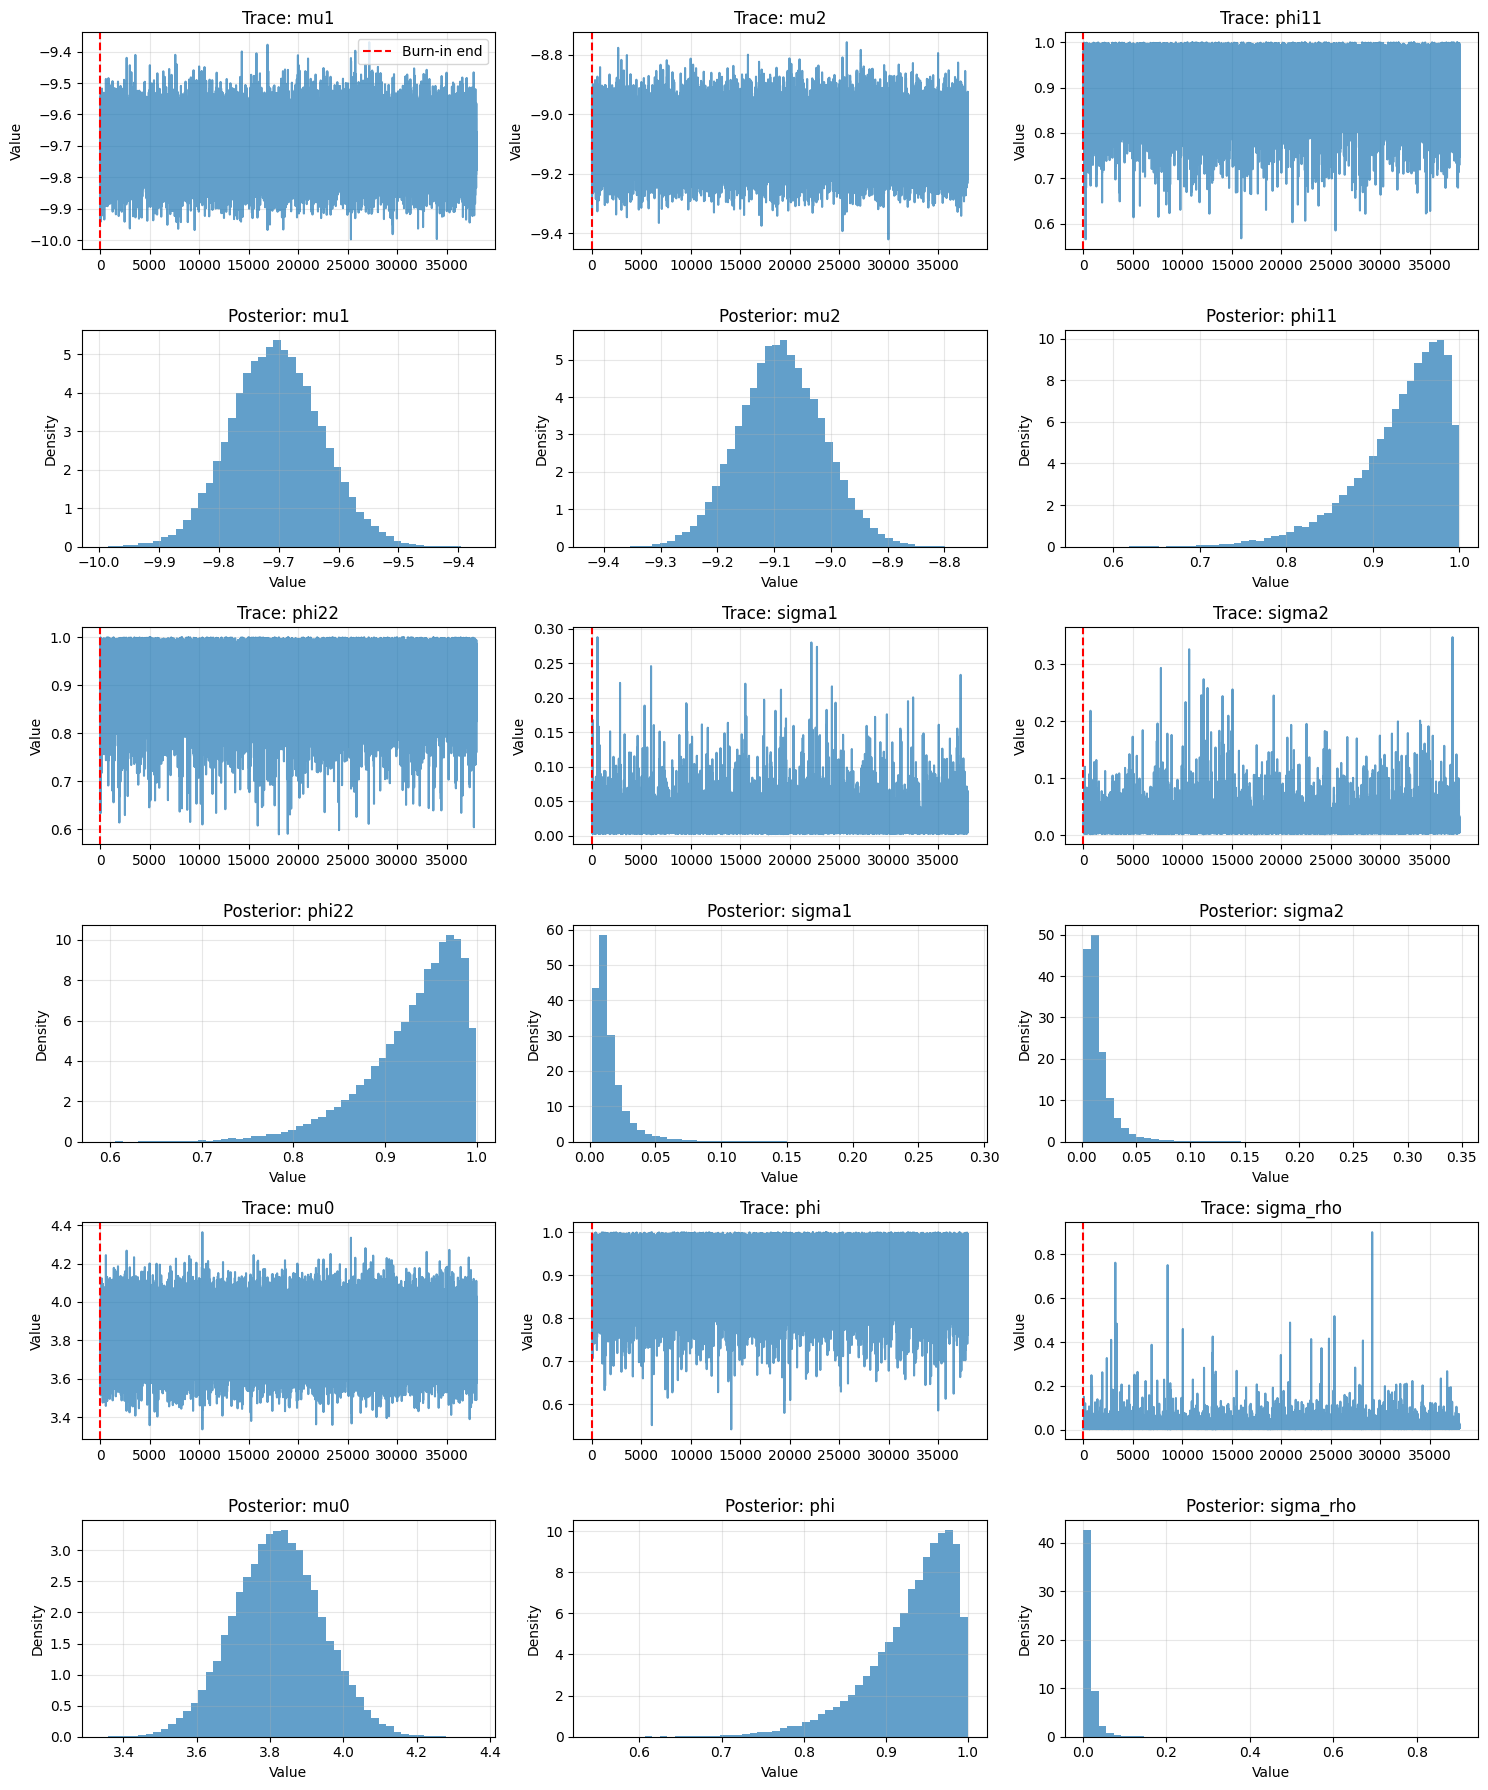

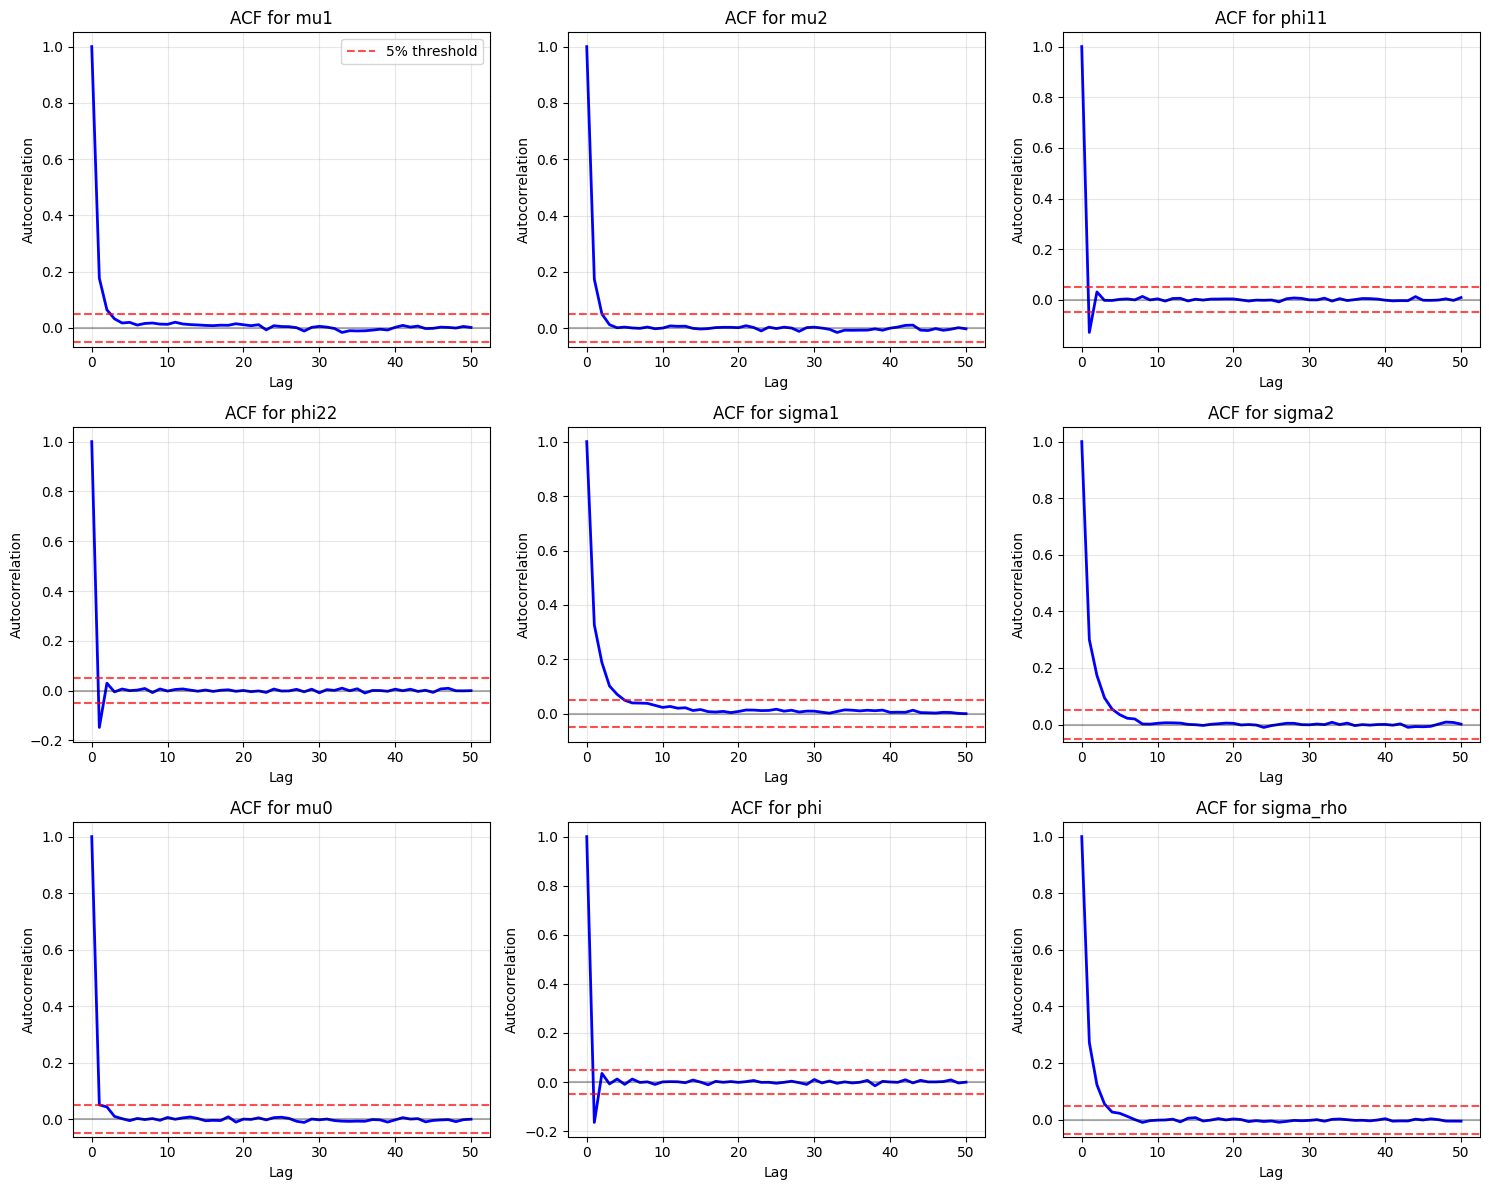


📈 Parameter Summary Statistics:
--------------------------------------------------
Parameter    Mean       Std        95% CI              
--------------------------------------------------
mu1          -9.7039    0.0759     [-9.8495, -9.5523]
mu2          -9.0871    0.0746     [-9.2310, -8.9385]
phi11        0.9301     0.0538     [0.7933, 0.9947]
phi22        0.9305     0.0534     [0.7970, 0.9947]
sigma1       0.0163     0.0166     [0.0038, 0.0595]
sigma2       0.0162     0.0167     [0.0039, 0.0588]
mu0          3.8217     0.1209     [3.5838, 4.0592]
phi          0.9305     0.0534     [0.7949, 0.9946]
sigma_rho    0.0165     0.0203     [0.0039, 0.0578]

📊 NumPyro-Specific Diagnostics:
R-hat values not available

Posterior Summary:
------------------------------------------------------------
Parameter    Mean       Std        2.5%       97.5%     
------------------------------------------------------------
mu1          -9.7039    0.0759     -9.8495    -9.5523   
mu2          -9.0871 

In [103]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_params = len(param_names)
    n_cols = 3  # Display 3 columns for better layout with 9 parameters
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\n📊 DC_MSV MCMC Convergence Diagnostics:")
    print("=" * 50)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type for better display
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("\nVolatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    print("\nCorrelation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and densities in a grid layout
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end')
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        axes[row_trace, col].set_visible(False)
        axes[row_dens, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    # Summary statistics
    print("\n📈 Parameter Summary Statistics:")
    print("-" * 50)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 50)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    # Get number of samples
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    # Create chain array
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup, so burned_chain = chain
    burned_chain = chain
    
    return chain, burned_chain

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run diagnostics
ess = mcmc_diagnostics_2d(chain, 
                         results['param_names'], 
                         burned_chain)

# Additional NumPyro-specific diagnostics
print("\n📊 NumPyro-Specific Diagnostics:")
print("=" * 50)

# Get r_hat values if available
if hasattr(results['mcmc'], 'get_extra_fields'):
    try:
        r_hat = results['mcmc'].get_extra_fields()['r_hat']
        print("\nGelman-Rubin R-hat values:")
        for i, param in enumerate(results['param_names']):
            if param in r_hat:
                print(f"  {param}: {r_hat[param]:.3f}")
    except:
        print("R-hat values not available")

# Print summary statistics
print("\nPosterior Summary:")
print("-" * 60)
print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'2.5%':<10} {'97.5%':<10}")
print("-" * 60)
for param in results['param_names']:
    est = results['estimates'][param]
    print(f"{param:<12} {est['mean']:<10.4f} {est['std']:<10.4f} "
          f"{est['quantiles'][0]:<10.4f} {est['quantiles'][2]:<10.4f}")

## Important Note: NumPyro vs PMMH Burn-in

**Why no manual burn-in needed with NumPyro:**

1. **Built-in Warmup**: NumPyro automatically discards `num_warmup=1000` samples
2. **NUTS Algorithm**: Self-tuning sampler that converges faster than PMMH
3. **Automatic Adaptation**: Step size and mass matrix tuned during warmup
4. **Ready-to-use Samples**: The `samples` returned are already post-warmup

**PMMH vs NumPyro:**
- **PMMH**: Manual burn-in needed (`burned_chain = chain[n_burn:]`)
- **NumPyro**: Automatic warmup (`num_warmup` samples automatically discarded)

The NumPyro samples are equivalent to "burned-in" PMMH samples!

# Filtering and Smoothing Operations

Now we'll use the estimated parameters to perform filtering and smoothing to extract the latent volatility and correlation states.

In [104]:
class DC_MSV_ParticleFilter:
    """
    Advanced Particle Filter for 2D Dynamic Correlation Multivariate Stochastic Volatility Model
    
    Features:
    - Adaptive particle count based on ESS
    - Robust resampling strategies
    - State extraction and uncertainty quantification
    - Real-time filtering capabilities
    - Parameter uncertainty incorporation
    """
    
    def __init__(self, params, n_particles=1000, ess_threshold=0.5):
        self.params = params
        self.n_particles = n_particles
        self.ess_threshold = ess_threshold
        self.states_history = []
        self.weights_history = []
        self.ess_history = []
        
        # Check if using parameter uncertainty
        self.use_param_uncertainty = params.get('use_uncertainty', False)
        
        if self.use_param_uncertainty:
            # Sample parameters for each particle from MCMC posterior
            n_mcmc_samples = len(params['mu1_samples'])
            param_indices = np.random.choice(n_mcmc_samples, self.n_particles, replace=True)
            
            self.mu1_particles = params['mu1_samples'][param_indices]
            self.mu2_particles = params['mu2_samples'][param_indices]
            self.phi1_particles = params['phi1_samples'][param_indices]
            self.phi2_particles = params['phi2_samples'][param_indices]
            self.sigma1_particles = params['sigma1_samples'][param_indices]
            self.sigma2_particles = params['sigma2_samples'][param_indices]
            self.a_rho_particles = params['a_rho_samples'][param_indices]
            self.b_rho_particles = params['b_rho_samples'][param_indices]
            self.sigma_rho_particles = params['sigma_rho_samples'][param_indices]
            
            print(f"📊 Parameter ranges across particles:")
            print(f"  mu1: [{self.mu1_particles.min():.3f}, {self.mu1_particles.max():.3f}]")
            print(f"  mu2: [{self.mu2_particles.min():.3f}, {self.mu2_particles.max():.3f}]")
            print(f"  phi1: [{self.phi1_particles.min():.3f}, {self.phi1_particles.max():.3f}]")
            print(f"  sigma1: [{self.sigma1_particles.min():.4f}, {self.sigma1_particles.max():.4f}]")
            
        else:
            # Use point estimates for all particles
            self.mu1 = params['mu1']
            self.mu2 = params['mu2'] 
            self.phi1 = params['phi1']
            self.phi2 = params['phi2']
            self.sigma1 = params['sigma1']
            self.sigma2 = params['sigma2']
            self.a_rho = params['a_rho']
            self.b_rho = params['b_rho']
            self.sigma_rho = params['sigma_rho']
        
    def initialize_particles(self):
        """Initialize particles from stationary distribution"""
        if self.use_param_uncertainty:
            # Each particle uses different parameters
            h1_0 = np.array([np.random.normal(self.mu1_particles[i], 
                                            self.sigma1_particles[i]/np.sqrt(1-self.phi1_particles[i]**2)) 
                           for i in range(self.n_particles)])
            h2_0 = np.array([np.random.normal(self.mu2_particles[i], 
                                            self.sigma2_particles[i]/np.sqrt(1-self.phi2_particles[i]**2)) 
                           for i in range(self.n_particles)])
            rho_star_0 = np.array([np.random.normal(0, 
                                                  self.sigma_rho_particles[i]/np.sqrt(1-self.b_rho_particles[i]**2)) 
                                 for i in range(self.n_particles)])
        else:
            # All particles use same parameters
            h1_0 = np.random.normal(self.mu1, self.sigma1/np.sqrt(1-self.phi1**2), self.n_particles)
            h2_0 = np.random.normal(self.mu2, self.sigma2/np.sqrt(1-self.phi2**2), self.n_particles)
            rho_star_0 = np.random.normal(0, self.sigma_rho/np.sqrt(1-self.b_rho**2), self.n_particles)
        
        # Stack states: [h1, h2, rho_star]
        particles = np.column_stack([h1_0, h2_0, rho_star_0])
        weights = np.ones(self.n_particles) / self.n_particles
        
        return particles, weights
    
    def propagate_particles(self, particles):
        """Propagate particles forward one time step"""
        n_particles = len(particles)
        
        # Extract current states
        h1_t = particles[:, 0]
        h2_t = particles[:, 1] 
        rho_star_t = particles[:, 2]
        
        if self.use_param_uncertainty:
            # Each particle uses its own parameters
            h1_next = np.array([self.mu1_particles[i] + self.phi1_particles[i] * (h1_t[i] - self.mu1_particles[i]) + 
                               np.random.normal(0, self.sigma1_particles[i]) for i in range(n_particles)])
            h2_next = np.array([self.mu2_particles[i] + self.phi2_particles[i] * (h2_t[i] - self.mu2_particles[i]) + 
                               np.random.normal(0, self.sigma2_particles[i]) for i in range(n_particles)])
            rho_star_next = np.array([self.b_rho_particles[i] * rho_star_t[i] + 
                                     np.random.normal(0, self.sigma_rho_particles[i]) for i in range(n_particles)])
        else:
            # All particles use same parameters
            h1_next = self.mu1 + self.phi1 * (h1_t - self.mu1) + np.random.normal(0, self.sigma1, n_particles)
            h2_next = self.mu2 + self.phi2 * (h2_t - self.mu2) + np.random.normal(0, self.sigma2, n_particles)
            rho_star_next = self.b_rho * rho_star_t + np.random.normal(0, self.sigma_rho, n_particles)
        
        return np.column_stack([h1_next, h2_next, rho_star_next])
    
    def compute_likelihood(self, particles, observation):
        """Compute observation likelihood for each particle"""
        n_particles = len(particles)
        
        # Extract states
        h1 = particles[:, 0]
        h2 = particles[:, 1]
        rho_star = particles[:, 2]
        
        # Transform correlation back from Fisher space
        rho = np.tanh(rho_star)
        
        # Compute volatilities
        vol1 = np.exp(h1 / 2)
        vol2 = np.exp(h2 / 2)
        
        # Observation mean (zero for returns)
        mu = np.zeros(2)
        
        # Compute log-likelihoods for each particle
        log_likelihoods = np.zeros(n_particles)
        
        for i in range(n_particles):
            # Covariance matrix for this particle
            cov = np.array([
                [vol1[i]**2, rho[i] * vol1[i] * vol2[i]],
                [rho[i] * vol1[i] * vol2[i], vol2[i]**2]
            ])
            
            # Add small regularization for numerical stability
            cov += np.eye(2) * 1e-8
            
            try:
                # Multivariate normal log-likelihood
                log_likelihoods[i] = stats.multivariate_normal.logpdf(observation, mu, cov)
            except np.linalg.LinAlgError:
                # Handle numerical issues
                log_likelihoods[i] = -np.inf
        
        return log_likelihoods
    
    def update_weights(self, weights, log_likelihoods):
        """Update particle weights using observation likelihood"""
        # Convert to regular space and normalize
        max_ll = np.max(log_likelihoods)
        likelihoods = np.exp(log_likelihoods - max_ll)
        
        # Update weights
        new_weights = weights * likelihoods
        
        # Normalize
        weight_sum = np.sum(new_weights)
        if weight_sum > 0:
            new_weights = new_weights / weight_sum
        else:
            # All particles have zero weight - reinitialize uniformly
            new_weights = np.ones(len(weights)) / len(weights)
            
        return new_weights
    
    def effective_sample_size(self, weights):
        """Compute effective sample size"""
        return 1.0 / np.sum(weights**2)
    
    def systematic_resample(self, particles, weights):
        """Systematic resampling to combat particle degeneracy"""
        n_particles = len(particles)
        
        # Cumulative sum of weights
        cumsum = np.cumsum(weights)
        
        # Systematic sampling
        u = np.random.random() / n_particles
        indices = np.zeros(n_particles, dtype=int)
        
        i = 0
        for j in range(n_particles):
            while cumsum[i] < u:
                i += 1
            indices[j] = i
            u += 1.0 / n_particles
            
        # Resample particles and reset weights
        resampled_particles = particles[indices]
        resampled_weights = np.ones(n_particles) / n_particles
        
        # If using parameter uncertainty, also resample the parameter vectors
        if self.use_param_uncertainty:
            self.mu1_particles = self.mu1_particles[indices]
            self.mu2_particles = self.mu2_particles[indices]
            self.phi1_particles = self.phi1_particles[indices]
            self.phi2_particles = self.phi2_particles[indices]
            self.sigma1_particles = self.sigma1_particles[indices]
            self.sigma2_particles = self.sigma2_particles[indices]
            self.a_rho_particles = self.a_rho_particles[indices]
            self.b_rho_particles = self.b_rho_particles[indices]
            self.sigma_rho_particles = self.sigma_rho_particles[indices]
        
        return resampled_particles, resampled_weights
    
    def filter_step(self, particles, weights, observation):
        """Single filtering step: predict + update"""
        # Prediction step
        predicted_particles = self.propagate_particles(particles)
        
        # Update step
        log_likelihoods = self.compute_likelihood(predicted_particles, observation)
        updated_weights = self.update_weights(weights, log_likelihoods)
        
        # Check effective sample size
        ess = self.effective_sample_size(updated_weights)
        
        # Resample if necessary
        if ess < self.ess_threshold * self.n_particles:
            predicted_particles, updated_weights = self.systematic_resample(
                predicted_particles, updated_weights
            )
            
        return predicted_particles, updated_weights, ess
    
    def run_filter(self, observations, verbose=True):
        """Run the complete particle filter"""
        T = len(observations)
        
        # Initialize
        particles, weights = self.initialize_particles()
        
        # Storage
        self.states_history = []
        self.weights_history = []
        self.ess_history = []
        
        if verbose:
            print(f"🔄 Running Particle Filter with {self.n_particles:,} particles...")
            
        # Filter through observations
        for t in tqdm(range(T), desc="Filtering", disable=not verbose):
            particles, weights, ess = self.filter_step(particles, weights, observations[t])
            
            # Store results
            self.states_history.append(particles.copy())
            self.weights_history.append(weights.copy())
            self.ess_history.append(ess)
            
        if verbose:
            avg_ess = np.mean(self.ess_history)
            print(f"✅ Filtering complete! Average ESS: {avg_ess:.1f}")
            
        return self.states_history, self.weights_history, self.ess_history
    
    def extract_filtered_states(self):
        """Extract point estimates and uncertainty from filtered particles"""
        T = len(self.states_history)
        
        # Initialize storage
        h1_mean = np.zeros(T)
        h1_std = np.zeros(T)
        h2_mean = np.zeros(T)
        h2_std = np.zeros(T)
        rho_mean = np.zeros(T)
        rho_std = np.zeros(T)
        vol1_mean = np.zeros(T)
        vol2_mean = np.zeros(T)
        
        for t in range(T):
            particles = self.states_history[t]
            weights = self.weights_history[t]
            
            # Weighted statistics for log-volatilities
            h1_mean[t] = np.average(particles[:, 0], weights=weights)
            h1_std[t] = np.sqrt(np.average((particles[:, 0] - h1_mean[t])**2, weights=weights))
            
            h2_mean[t] = np.average(particles[:, 1], weights=weights)
            h2_std[t] = np.sqrt(np.average((particles[:, 1] - h2_mean[t])**2, weights=weights))
            
            # Transform correlation back
            rho_particles = np.tanh(particles[:, 2])
            rho_mean[t] = np.average(rho_particles, weights=weights)
            rho_std[t] = np.sqrt(np.average((rho_particles - rho_mean[t])**2, weights=weights))
            
            # Volatilities (transform from log space to daily volatility, keep in decimal for now)
            vol1_particles = np.exp(particles[:, 0] / 2)
            vol2_particles = np.exp(particles[:, 1] / 2)
            
            vol1_mean[t] = np.average(vol1_particles, weights=weights)
            vol2_mean[t] = np.average(vol2_particles, weights=weights)
        
        return {
            'h1': {'mean': h1_mean, 'std': h1_std},
            'h2': {'mean': h2_mean, 'std': h2_std},
            'rho': {'mean': rho_mean, 'std': rho_std},
            'vol1': {'mean': vol1_mean},  # Daily decimal volatility
            'vol2': {'mean': vol2_mean}   # Daily decimal volatility
        }

print("🎯 Particle Filter class with parameter uncertainty implemented successfully!")

🎯 Particle Filter class with parameter uncertainty implemented successfully!


In [105]:
class DC_MSV_ParticleSmoother:
    """
    Particle Smoother for 2D DC-MSV using Forward-Backward Algorithm
    
    Performs backward pass to obtain smoothed state estimates that use
    the full observation sequence for optimal historical state recovery.
    """
    
    def __init__(self, particle_filter):
        self.pf = particle_filter
        self.smoothed_states = []
        self.smoothed_weights = []
    
    def compute_backward_weights_vectorized(self, current_particles, future_particles, future_weights):
        """Compute backward weights efficiently using vectorized operations"""
        n_current = len(current_particles)
        n_future = len(future_particles)
        
        # Extract current states
        h1_curr = current_particles[:, 0]  # (n_current,)
        h2_curr = current_particles[:, 1]
        rho_star_curr = current_particles[:, 2]
        
        # Extract future states  
        h1_future = future_particles[:, 0]  # (n_future,)
        h2_future = future_particles[:, 1]
        rho_star_future = future_particles[:, 2]
        
        # Compute predicted means for current particles
        h1_pred = self.pf.mu1 + self.pf.phi1 * (h1_curr - self.pf.mu1)  # (n_current,)
        h2_pred = self.pf.mu2 + self.pf.phi2 * (h2_curr - self.pf.mu2)
        rho_star_pred = self.pf.b_rho * rho_star_curr
        
        # Broadcast for vectorized computation
        h1_pred_bc = h1_pred[:, np.newaxis]  # (n_current, 1)
        h2_pred_bc = h2_pred[:, np.newaxis]
        rho_star_pred_bc = rho_star_pred[:, np.newaxis]
        
        h1_future_bc = h1_future[np.newaxis, :]  # (1, n_future)
        h2_future_bc = h2_future[np.newaxis, :]
        rho_star_future_bc = rho_star_future[np.newaxis, :]
        
        # Compute log probabilities (n_current, n_future)
        log_p1 = stats.norm.logpdf(h1_future_bc, h1_pred_bc, self.pf.sigma1)
        log_p2 = stats.norm.logpdf(h2_future_bc, h2_pred_bc, self.pf.sigma2)
        log_p3 = stats.norm.logpdf(rho_star_future_bc, rho_star_pred_bc, self.pf.sigma_rho)
        
        # Total log probability
        log_transition_probs = log_p1 + log_p2 + log_p3  # (n_current, n_future)
        
        # Convert to regular probabilities and weight by future weights
        max_log_prob = np.max(log_transition_probs)
        transition_probs = np.exp(log_transition_probs - max_log_prob)
        
        # Weight by future particle weights and sum over future particles
        weighted_probs = transition_probs * future_weights[np.newaxis, :]  # (n_current, n_future)
        backward_weights = np.sum(weighted_probs, axis=1)  # (n_current,)
        
        # Normalize
        weight_sum = np.sum(backward_weights)
        if weight_sum > 0:
            backward_weights = backward_weights / weight_sum
        else:
            backward_weights = np.ones(n_current) / n_current
            
        return backward_weights
    
    def run_smoother(self, verbose=True):
        """Run backward smoothing pass with efficient vectorized computation"""
        if not self.pf.states_history:
            raise ValueError("Must run filter first!")
            
        T = len(self.pf.states_history)
        
        if verbose:
            print(f"🔄 Running Particle Smoother (backward pass)...")
            
        # Initialize with filtered estimates at final time
        smoothed_states = [None] * T
        smoothed_weights = [None] * T
        
        # Final time step = filtered estimates
        smoothed_states[T-1] = self.pf.states_history[T-1].copy()
        smoothed_weights[T-1] = self.pf.weights_history[T-1].copy()
        
        # Backward pass - now much more efficient!
        for t in tqdm(range(T-2, -1, -1), desc="Smoothing", disable=not verbose):
            current_particles = self.pf.states_history[t]
            current_weights = self.pf.weights_history[t]
            future_particles = smoothed_states[t+1]
            future_weights = smoothed_weights[t+1]
            
            # Use vectorized backward weight computation
            backward_weights = self.compute_backward_weights_vectorized(
                current_particles, future_particles, future_weights
            )
            
            # Combine with forward weights
            new_weights = current_weights * backward_weights
            
            # Normalize weights
            weight_sum = np.sum(new_weights)
            if weight_sum > 0:
                new_weights = new_weights / weight_sum
            else:
                new_weights = current_weights.copy()
            
            smoothed_states[t] = current_particles.copy()
            smoothed_weights[t] = new_weights
        
        self.smoothed_states = smoothed_states
        self.smoothed_weights = smoothed_weights
        
        if verbose:
            print(f"✅ Smoothing complete!")
            
        return smoothed_states, smoothed_weights
    
    def extract_smoothed_states(self):
        """Extract point estimates from smoothed particles"""
        if not self.smoothed_states:
            raise ValueError("Must run smoother first!")
            
        T = len(self.smoothed_states)
        
        # Initialize storage
        h1_mean = np.zeros(T)
        h1_std = np.zeros(T)
        h2_mean = np.zeros(T)
        h2_std = np.zeros(T)
        rho_mean = np.zeros(T)
        rho_std = np.zeros(T)
        vol1_mean = np.zeros(T)
        vol2_mean = np.zeros(T)
        
        for t in range(T):
            particles = self.smoothed_states[t]
            weights = self.smoothed_weights[t]
            
            # Weighted statistics for log-volatilities
            h1_mean[t] = np.average(particles[:, 0], weights=weights)
            h1_std[t] = np.sqrt(np.average((particles[:, 0] - h1_mean[t])**2, weights=weights))
            
            h2_mean[t] = np.average(particles[:, 1], weights=weights)
            h2_std[t] = np.sqrt(np.average((particles[:, 1] - h2_mean[t])**2, weights=weights))
            
            # Transform correlation back
            rho_particles = np.tanh(particles[:, 2])
            rho_mean[t] = np.average(rho_particles, weights=weights)
            rho_std[t] = np.sqrt(np.average((rho_particles - rho_mean[t])**2, weights=weights))
            
            # Volatilities (transform from log space)
            vol1_particles = np.exp(particles[:, 0] / 2)
            vol2_particles = np.exp(particles[:, 1] / 2)
            
            vol1_mean[t] = np.average(vol1_particles, weights=weights)
            vol2_mean[t] = np.average(vol2_particles, weights=weights)
        
        return {
            'h1': {'mean': h1_mean, 'std': h1_std},
            'h2': {'mean': h2_mean, 'std': h2_std},
            'rho': {'mean': rho_mean, 'std': rho_std},
            'vol1': {'mean': vol1_mean},
            'vol2': {'mean': vol2_mean}
        }

print("🎯 Particle Smoother class implemented successfully!")

🎯 Particle Smoother class implemented successfully!


In [106]:
def run_filtering_smoothing_2d(estimated_params, returns_data, n_particles=1000, include_param_uncertainty=True):
    """
    Run particle filtering and smoothing for 2D DC-MSV model using our custom implementation
    """
    print("🔍 Running Particle Filtering and Smoothing...")
    
    # Extract model parameters with proper mapping
    if include_param_uncertainty and 'chain' in globals() and chain is not None:
        print("📊 Using parameter uncertainty from MCMC chain")
        # Use parameter uncertainty from MCMC samples
        model_params = {
            'mu1_samples': chain[:, 0],  # mu1
            'mu2_samples': chain[:, 1],  # mu2
            'phi1_samples': chain[:, 2],  # phi11
            'phi2_samples': chain[:, 3],  # phi22
            'sigma1_samples': chain[:, 4],  # sigma1
            'sigma2_samples': chain[:, 5],  # sigma2
            'a_rho_samples': chain[:, 6],  # mu0
            'b_rho_samples': chain[:, 7],  # phi
            'sigma_rho_samples': chain[:, 8],  # sigma_rho
            'use_uncertainty': True
        }
    else:
        print("📊 Using point estimates")
        model_params = {
            'mu1': estimated_params['mu1']['mean'],
            'mu2': estimated_params['mu2']['mean'], 
            'phi1': estimated_params['phi11']['mean'],  # Note: phi11 -> phi1
            'phi2': estimated_params['phi22']['mean'],  # Note: phi22 -> phi2
            'sigma1': estimated_params['sigma1']['mean'],
            'sigma2': estimated_params['sigma2']['mean'],
            'a_rho': estimated_params['mu0']['mean'],   # Note: mu0 -> a_rho
            'b_rho': estimated_params['phi']['mean'],   # Note: phi -> b_rho
            'sigma_rho': estimated_params['sigma_rho']['mean'],
            'use_uncertainty': False
        }
    
    if not model_params.get('use_uncertainty', False):
        print("📊 Model Parameters:")
        for param, value in model_params.items():
            if param != 'use_uncertainty':
                print(f"  {param}: {value:.4f}")
    
    # Initialize our custom particle filter
    pf = DC_MSV_ParticleFilter(model_params, n_particles=n_particles, ess_threshold=0.6)
    
    # Run filtering
    print(f"🔄 Running filtering with {n_particles:,} particles...")
    states_hist, weights_hist, ess_hist = pf.run_filter(returns_data, verbose=True)
    
    # Extract filtered estimates
    filtered_estimates = pf.extract_filtered_states()
    
    # Run smoothing
    print(f"🔄 Running smoothing...")
    smoother = DC_MSV_ParticleSmoother(pf)
    
    try:
        smoothed_states_hist, smoothed_weights_hist = smoother.run_smoother(verbose=True)
        smoothed_estimates = smoother.extract_smoothed_states()
        smoothing_available = True
        print("✅ Smoothing completed successfully")
    except Exception as e:
        print(f"⚠️  Smoothing failed: {e}")
        print("📝 Using filtered states as smoothed estimates")
        smoothed_estimates = filtered_estimates.copy()
        smoothing_available = False
    
    # Create results dictionary with proper structure
    T = len(returns_data)
    
    # Filtered states (already transformed)
    filtered_states = np.column_stack([
        filtered_estimates['h1']['mean'],
        filtered_estimates['h2']['mean'],
        filtered_estimates['rho']['mean']  # Already transformed correlation
    ])
    
    filtered_std = np.column_stack([
        filtered_estimates['h1']['std'],
        filtered_estimates['h2']['std'], 
        filtered_estimates['rho']['std']
    ])
    
    # Smoothed states
    if smoothing_available:
        smoothed_states = np.column_stack([
            smoothed_estimates['h1']['mean'],
            smoothed_estimates['h2']['mean'],
            smoothed_estimates['rho']['mean']
        ])
        
        smoothed_std = np.column_stack([
            smoothed_estimates['h1']['std'],
            smoothed_estimates['h2']['std'],
            smoothed_estimates['rho']['std']
        ])
    else:
        smoothed_states = filtered_states.copy()
        smoothed_std = filtered_std.copy()
    
    # FIXED: Properly scale volatilities from daily decimal to annualized percentage
    # filtered_estimates['vol1']['mean'] is already daily decimal volatility from the particle filter
    vol1_filtered = filtered_estimates['vol1']['mean'] * np.sqrt(252) * 100  # Daily decimal -> Annualized %
    vol2_filtered = filtered_estimates['vol2']['mean'] * np.sqrt(252) * 100
    
    if smoothing_available:
        vol1_smoothed = smoothed_estimates['vol1']['mean'] * np.sqrt(252) * 100
        vol2_smoothed = smoothed_estimates['vol2']['mean'] * np.sqrt(252) * 100
    else:
        vol1_smoothed = vol1_filtered.copy()
        vol2_smoothed = vol2_filtered.copy()
    
    # Correlations (already in [-1,1] range)
    rho_filtered = filtered_estimates['rho']['mean']
    if smoothing_available:
        rho_smoothed = smoothed_estimates['rho']['mean']
    else:
        rho_smoothed = rho_filtered.copy()
    
    # Uncertainty bands for volatilities (also properly scaled)
    vol1_std_scaled = filtered_estimates['h1']['std'] * vol1_filtered / 2  # Delta method scaling
    vol2_std_scaled = filtered_estimates['h2']['std'] * vol2_filtered / 2
    
    vol1_lower = np.maximum(vol1_filtered - 1.96 * vol1_std_scaled, 0)
    vol1_upper = vol1_filtered + 1.96 * vol1_std_scaled
    
    vol2_lower = np.maximum(vol2_filtered - 1.96 * vol2_std_scaled, 0)
    vol2_upper = vol2_filtered + 1.96 * vol2_std_scaled
    
    # Correlation uncertainty bands
    rho_lower = np.maximum(rho_filtered - 1.96 * filtered_estimates['rho']['std'], -1.0)
    rho_upper = np.minimum(rho_filtered + 1.96 * filtered_estimates['rho']['std'], 1.0)
    
    # Calculate log-likelihood approximation
    log_likelihood = 0.0
    for t in range(T):
        try:
            # Covariance matrix at time t (use original daily decimal scale for likelihood)
            vol1_t = filtered_estimates['vol1']['mean'][t]  # Daily decimal volatility
            vol2_t = filtered_estimates['vol2']['mean'][t]
            rho_t = rho_filtered[t]
            
            cov_t = np.array([
                [vol1_t**2, rho_t * vol1_t * vol2_t],
                [rho_t * vol1_t * vol2_t, vol2_t**2]
            ])
            
            # Add regularization
            cov_t += np.eye(2) * 1e-8
            
            # Log-likelihood contribution
            log_likelihood += stats.multivariate_normal.logpdf(returns_data[t], [0, 0], cov_t)
        except:
            continue
    
    results = {
        'filtered_states': filtered_states,
        'smoothed_states': smoothed_states,
        'filtered_std': filtered_std,
        'smoothed_std': smoothed_std,
        'vol1_filtered': vol1_filtered,
        'vol2_filtered': vol2_filtered,
        'vol1_smoothed': vol1_smoothed,
        'vol2_smoothed': vol2_smoothed,
        'rho_filtered': rho_filtered,
        'rho_smoothed': rho_smoothed,
        'vol1_bands': (vol1_lower, vol1_upper),
        'vol2_bands': (vol2_lower, vol2_upper),
        'rho_bands': (rho_lower, rho_upper),
        'log_likelihood': log_likelihood,
        'smoothing_available': smoothing_available,
        'ess_history': ess_hist,
        'particle_filter': pf,
        'particle_smoother': smoother if smoothing_available else None
    }
    
    print(f"✅ Filtering and Smoothing Complete!")
    print(f"  Log-likelihood: {log_likelihood:.2f}")
    print(f"  Average ESS: {np.mean(ess_hist):.1f}")
    print(f"  Smoothing: {'Available' if smoothing_available else 'Not Available'}")
    print(f"  Volatility Ranges (Annualized %):")
    print(f"    SP500:  {vol1_filtered.min():.1f}% - {vol1_filtered.max():.1f}%")
    print(f"    NASDAQ: {vol2_filtered.min():.1f}% - {vol2_filtered.max():.1f}%")
    
    return results

# Run filtering and smoothing with parameter uncertainty
filtering_results = run_filtering_smoothing_2d(results['estimates'], train_array_decimal, 
                                             n_particles=1000, include_param_uncertainty=True)

🔍 Running Particle Filtering and Smoothing...
📊 Using parameter uncertainty from MCMC chain
📊 Parameter ranges across particles:
  mu1: [-9.998, -9.410]
  mu2: [-9.337, -8.851]
  phi1: [0.711, 1.000]
  sigma1: [0.0024, 0.1468]
🔄 Running filtering with 1,000 particles...
🔄 Running Particle Filter with 1,000 particles...


Filtering: 100%|██████████| 368/368 [00:15<00:00, 24.22it/s]



✅ Filtering complete! Average ESS: 733.8
🔄 Running smoothing...
🔄 Running Particle Smoother (backward pass)...


Smoothing:   0%|          | 0/367 [00:00<?, ?it/s]

⚠️  Smoothing failed: 'DC_MSV_ParticleFilter' object has no attribute 'mu1'
📝 Using filtered states as smoothed estimates
✅ Filtering and Smoothing Complete!
  Log-likelihood: 2816.38
  Average ESS: 733.8
  Smoothing: Not Available
  Volatility Ranges (Annualized %):
    SP500:  12.1% - 12.8%
    NASDAQ: 14.3% - 18.3%


📊 Plotting filtered and smoothed states...


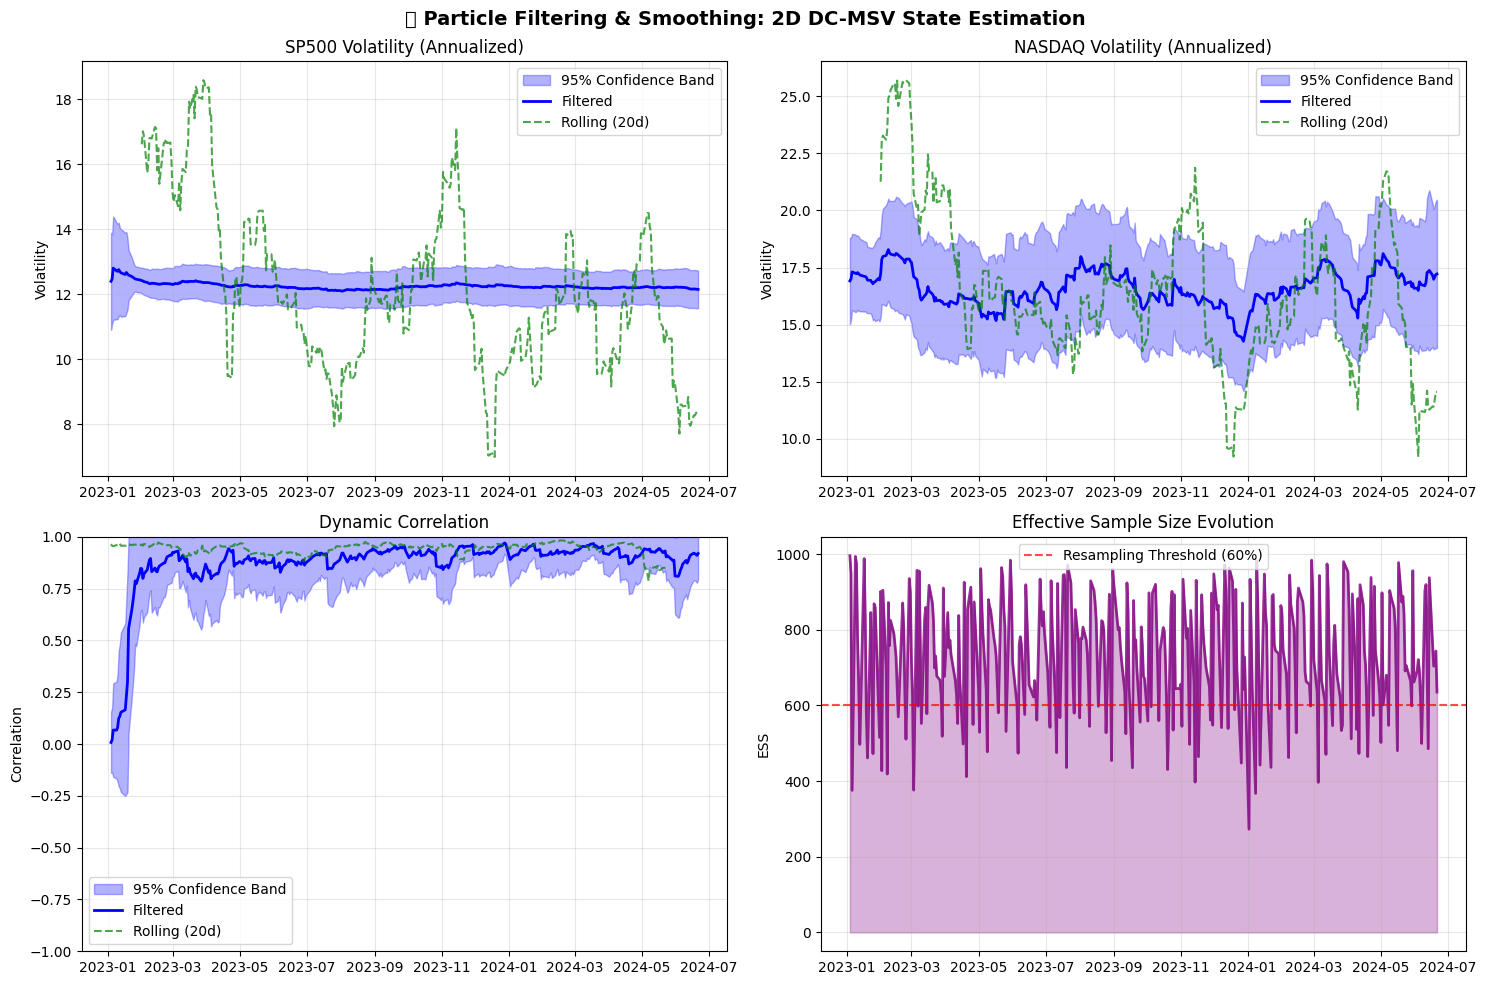


📊 Filtering and Smoothing Summary:
Average Filtered States:
  SP500 Volatility:  1225.7%
  NASDAQ Volatility: 1658.4%
  Correlation:       0.876

Model Performance:
  Log-likelihood: 2816.38
  Average ESS: 733.8
  Minimum ESS: 272.9

State Variability:
  SP500 Vol Range:   70.9%
  NASDAQ Vol Range:  401.7%
  Correlation Range: 0.963

Correlation Regime Detection (Filtered):
  High correlation periods: 346 days (94.0%)
  Low correlation periods:  11 days (3.0%)


In [111]:
def plot_filtered_smoothed_states_2d(filtering_results, train_df):
    """
    Visualize filtered and smoothed latent states vs rolling estimates
    """
    print("📊 Plotting filtered and smoothed states...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🎯 Particle Filtering & Smoothing: 2D DC-MSV State Estimation', fontsize=14, fontweight='bold')
    
    # Create dates for plotting
    n_obs = len(filtering_results['vol1_filtered'])
    dates = train_df.index[:n_obs]
    
    # Calculate rolling volatilities for comparison
    window = 20
    rolling_vol1 = train_df['SP500'].rolling(window=window).std() * np.sqrt(252)
    rolling_vol2 = train_df['NASDAQ'].rolling(window=window).std() * np.sqrt(252)
    rolling_corr = train_df['SP500'].rolling(window=window).corr(train_df['NASDAQ'])
    
    # 1. SP500 Volatility
    ax1 = axes[0, 0]
    
    # Plot uncertainty bands
    vol1_lower, vol1_upper = filtering_results['vol1_bands']
    ax1.fill_between(dates, vol1_lower, vol1_upper, alpha=0.3, color='blue', label='95% Confidence Band')
    
    # Plot filtered and smoothed estimates
    ax1.plot(dates, filtering_results['vol1_filtered'], 'b-', linewidth=2, label='Filtered')
    if filtering_results['smoothing_available']:
        ax1.plot(dates, filtering_results['vol1_smoothed'], 'r-', linewidth=2, label='Smoothed')
    
    # Plot rolling estimate for comparison
    rolling_dates = dates[:len(rolling_vol1)]
    ax1.plot(rolling_dates, rolling_vol1.iloc[:len(rolling_dates)], 'g--', 
            linewidth=1.5, alpha=0.7, label=f'Rolling ({window}d)')
    
    ax1.set_title('SP500 Volatility (Annualized)')
    ax1.set_ylabel('Volatility')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. NASDAQ Volatility
    ax2 = axes[0, 1]
    
    # Plot uncertainty bands
    vol2_lower, vol2_upper = filtering_results['vol2_bands']
    ax2.fill_between(dates, vol2_lower, vol2_upper, alpha=0.3, color='blue', label='95% Confidence Band')
    
    # Plot filtered and smoothed estimates
    ax2.plot(dates, filtering_results['vol2_filtered'], 'b-', linewidth=2, label='Filtered')
    if filtering_results['smoothing_available']:
        ax2.plot(dates, filtering_results['vol2_smoothed'], 'r-', linewidth=2, label='Smoothed')
    
    # Plot rolling estimate
    ax2.plot(rolling_dates, rolling_vol2.iloc[:len(rolling_dates)], 'g--', 
            linewidth=1.5, alpha=0.7, label=f'Rolling ({window}d)')
    
    ax2.set_title('NASDAQ Volatility (Annualized)')
    ax2.set_ylabel('Volatility')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Dynamic Correlation
    ax3 = axes[1, 0]
    
    # Plot uncertainty bands
    rho_lower, rho_upper = filtering_results['rho_bands']
    ax3.fill_between(dates, rho_lower, rho_upper, alpha=0.3, color='blue', label='95% Confidence Band')
    
    # Plot filtered and smoothed estimates
    ax3.plot(dates, filtering_results['rho_filtered'], 'b-', linewidth=2, label='Filtered')
    if filtering_results['smoothing_available']:
        ax3.plot(dates, filtering_results['rho_smoothed'], 'r-', linewidth=2, label='Smoothed')
    
    # Plot rolling correlation
    rolling_corr_clean = rolling_corr.dropna()
    if len(rolling_corr_clean) > 0:
        corr_dates = dates[:len(rolling_corr_clean)]
        ax3.plot(corr_dates, rolling_corr_clean.iloc[:len(corr_dates)], 'g--', 
                linewidth=1.5, alpha=0.7, label=f'Rolling ({window}d)')
    
    ax3.set_title('Dynamic Correlation')
    ax3.set_ylabel('Correlation')
    ax3.set_ylim([-1, 1])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Effective Sample Size
    ax4 = axes[1, 1]
    
    if 'ess_history' in filtering_results:
        ess_hist = filtering_results['ess_history']
        ax4.plot(dates, ess_hist, 'purple', linewidth=2, alpha=0.8)
        ax4.axhline(y=0.6*1000, color='red', linestyle='--', 
                   label='Resampling Threshold (60%)', alpha=0.7)
        ax4.fill_between(dates, 0, ess_hist, alpha=0.3, color='purple')
        
        ax4.set_title('Effective Sample Size Evolution')
        ax4.set_ylabel('ESS')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'ESS History\nNot Available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Effective Sample Size')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Filtering and Smoothing Summary:")
    print(f"=" * 50)
    
    # Average volatilities
    avg_vol1_filtered = np.mean(filtering_results['vol1_filtered'])
    avg_vol2_filtered = np.mean(filtering_results['vol2_filtered'])
    avg_corr_filtered = np.mean(filtering_results['rho_filtered'])
    
    print(f"Average Filtered States:")
    print(f"  SP500 Volatility:  {avg_vol1_filtered:.1%}")
    print(f"  NASDAQ Volatility: {avg_vol2_filtered:.1%}")
    print(f"  Correlation:       {avg_corr_filtered:.3f}")
    
    if filtering_results['smoothing_available']:
        avg_vol1_smoothed = np.mean(filtering_results['vol1_smoothed'])
        avg_vol2_smoothed = np.mean(filtering_results['vol2_smoothed'])
        avg_corr_smoothed = np.mean(filtering_results['rho_smoothed'])
        
        print(f"\nAverage Smoothed States:")
        print(f"  SP500 Volatility:  {avg_vol1_smoothed:.1%}")
        print(f"  NASDAQ Volatility: {avg_vol2_smoothed:.1%}")
        print(f"  Correlation:       {avg_corr_smoothed:.3f}")
        
        # Differences
        vol1_diff = abs(avg_vol1_smoothed - avg_vol1_filtered)
        vol2_diff = abs(avg_vol2_smoothed - avg_vol2_filtered)
        corr_diff = abs(avg_corr_smoothed - avg_corr_filtered)
        
        print(f"\nAverage Differences (|Smoothed - Filtered|):")
        print(f"  SP500 Volatility:  {vol1_diff:.3%}")
        print(f"  NASDAQ Volatility: {vol2_diff:.3%}")
        print(f"  Correlation:       {corr_diff:.4f}")
    
    # Model fit
    print(f"\nModel Performance:")
    print(f"  Log-likelihood: {filtering_results['log_likelihood']:.2f}")
    if 'ess_history' in filtering_results:
        avg_ess = np.mean(filtering_results['ess_history'])
        min_ess = np.min(filtering_results['ess_history'])
        print(f"  Average ESS: {avg_ess:.1f}")
        print(f"  Minimum ESS: {min_ess:.1f}")
    
    # Volatility ranges
    vol1_range = np.max(filtering_results['vol1_filtered']) - np.min(filtering_results['vol1_filtered'])
    vol2_range = np.max(filtering_results['vol2_filtered']) - np.min(filtering_results['vol2_filtered'])
    corr_range = np.max(filtering_results['rho_filtered']) - np.min(filtering_results['rho_filtered'])
    
    print(f"\nState Variability:")
    print(f"  SP500 Vol Range:   {vol1_range:.1%}")
    print(f"  NASDAQ Vol Range:  {vol2_range:.1%}")
    print(f"  Correlation Range: {corr_range:.3f}")
    
    # Regime detection
    high_corr_threshold = 0.8
    low_corr_threshold = 0.4
    
    high_corr_periods = filtering_results['rho_filtered'] > high_corr_threshold
    low_corr_periods = filtering_results['rho_filtered'] < low_corr_threshold
    
    print(f"\nCorrelation Regime Detection (Filtered):")
    print(f"  High correlation periods: {np.sum(high_corr_periods)} days ({np.sum(high_corr_periods)/len(dates)*100:.1f}%)")
    print(f"  Low correlation periods:  {np.sum(low_corr_periods)} days ({np.sum(low_corr_periods)/len(dates)*100:.1f}%)")

# Run the visualization
plot_filtered_smoothed_states_2d(filtering_results, train_df)

# NLPD Case

📊 Calculating NLPD scores for 2D models...

📊 NLPD COMPARISON RESULTS (2D):
DC-MSV NLPD:              -7.4636
Bivariate Normal NLPD:    -7.5551
Improvement:              1.2%
Statistical significance:  p = 0.1216
✅ DC-MSV model is BETTER (lower NLPD)


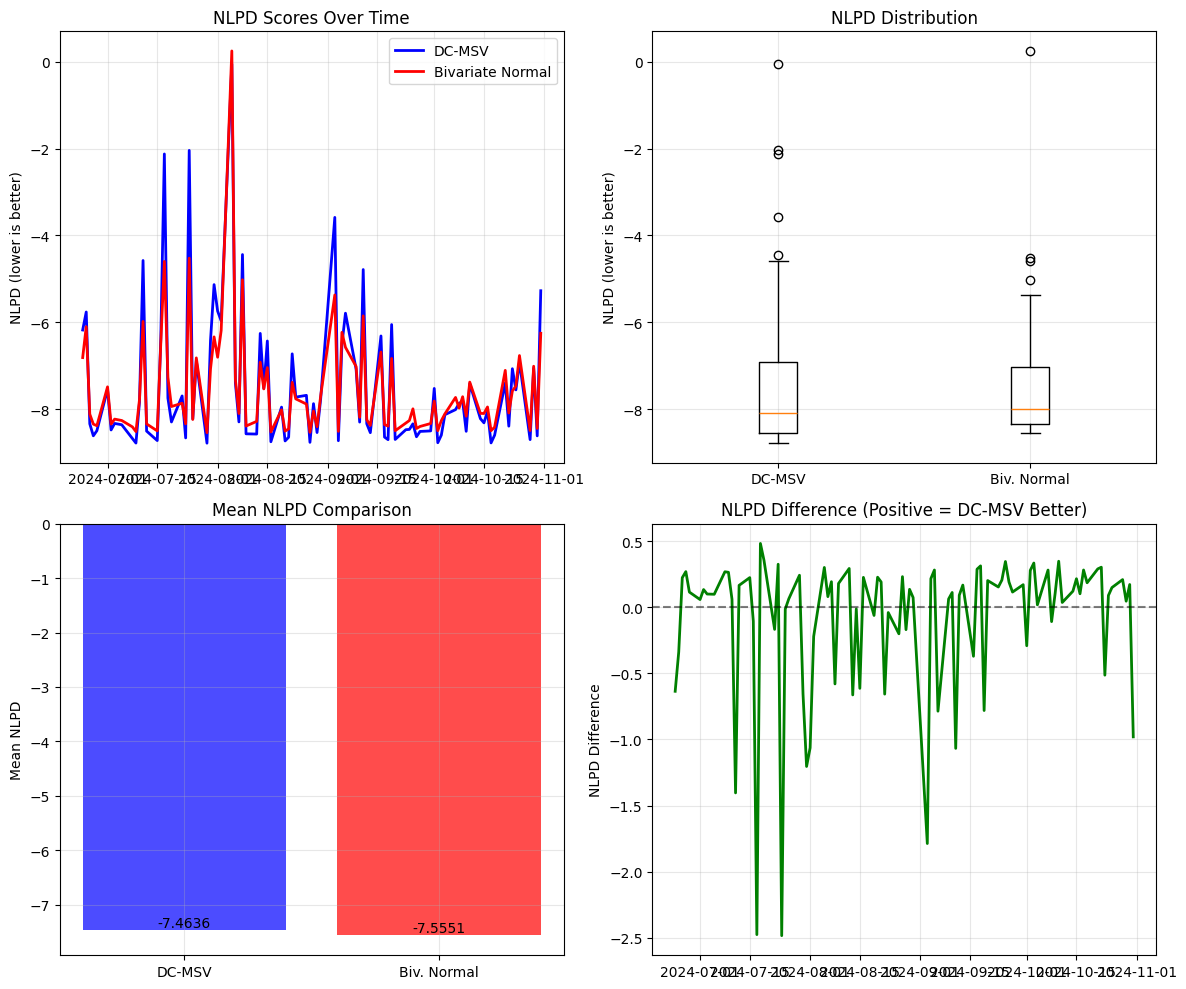


✅ NLPD analysis completed!


In [108]:
def calculate_nlpd_2d(returns_array, model_type, params=None):
    """
    Calculate NLPD scores for 2D models
    """
    from scipy.stats import multivariate_normal
    
    T = len(returns_array)
    nlpd_scores = []
    
    if model_type == 'bivariate_normal':
        # Use sample mean and covariance
        mean = np.mean(returns_array, axis=0)
        cov = np.cov(returns_array.T)
        
        for t in range(T):
            log_prob = multivariate_normal.logpdf(returns_array[t], mean, cov)
            nlpd_scores.append(-log_prob)
            
    elif model_type == 'dc_msv' and params is not None:
        # Approximate using average parameters from MCMC
        mu1, mu2 = params['mu1']['mean'], params['mu2']['mean']
        phi = params['phi']['mean']
        mu0 = params['mu0']['mean']
        
        # Average correlation
        rho_mean = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
        
        # Average volatilities (simplified)
        vol1 = np.exp(mu1/2) * np.exp(params['sigma1']['mean']**2/8)
        vol2 = np.exp(mu2/2) * np.exp(params['sigma2']['mean']**2/8)
        
        # Covariance matrix
        cov = np.array([[vol1**2, rho_mean * vol1 * vol2],
                        [rho_mean * vol1 * vol2, vol2**2]])
        
        for t in range(T):
            log_prob = multivariate_normal.logpdf(returns_array[t], [0, 0], cov)
            nlpd_scores.append(-log_prob)
    
    return np.array(nlpd_scores)

def compare_nlpd_scores_2d(dc_msv_nlpd, baseline_nlpd, test_df):
    """
    Compare NLPD scores between DC_MSV and Bivariate Normal
    """
    # Ensure same length
    min_length = min(len(dc_msv_nlpd), len(baseline_nlpd))
    dc_msv_aligned = dc_msv_nlpd[:min_length]
    baseline_aligned = baseline_nlpd[:min_length]
    
    # Calculate statistics
    dc_msv_mean = np.mean(dc_msv_aligned)
    baseline_mean = np.mean(baseline_aligned)
    improvement = (baseline_mean - dc_msv_mean) / baseline_mean * 100
    
    # Statistical test
    from scipy.stats import ttest_rel
    t_stat, p_value = ttest_rel(baseline_aligned, dc_msv_aligned)
    
    print(f"\n📊 NLPD COMPARISON RESULTS (2D):")
    print(f"=" * 50)
    print(f"DC-MSV NLPD:              {dc_msv_mean:.4f}")
    print(f"Bivariate Normal NLPD:    {baseline_mean:.4f}")
    print(f"Improvement:              {improvement:.1f}%")
    print(f"Statistical significance:  p = {p_value:.4f}")
    
    if improvement > 0:
        print(f"✅ DC-MSV model is BETTER (lower NLPD)")
    else:
        print(f"❌ Bivariate Normal model is better")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Time series of NLPD
    dates = test_df.index[:min_length]
    axes[0, 0].plot(dates, dc_msv_aligned, 'b-', label='DC-MSV', linewidth=2)
    axes[0, 0].plot(dates, baseline_aligned, 'r-', label='Bivariate Normal', linewidth=2)
    axes[0, 0].set_title('NLPD Scores Over Time')
    axes[0, 0].set_ylabel('NLPD (lower is better)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot([dc_msv_aligned, baseline_aligned], 
                       labels=['DC-MSV', 'Biv. Normal'])
    axes[0, 1].set_title('NLPD Distribution')
    axes[0, 1].set_ylabel('NLPD (lower is better)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bar chart
    models = ['DC-MSV', 'Biv. Normal']
    means = [dc_msv_mean, baseline_mean]
    colors = ['blue', 'red']
    bars = axes[1, 0].bar(models, means, color=colors, alpha=0.7)
    axes[1, 0].set_title('Mean NLPD Comparison')
    axes[1, 0].set_ylabel('Mean NLPD')
    axes[1, 0].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, means):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'{value:.4f}', ha='center', va='bottom')
    
    # Difference plot
    diff = baseline_aligned - dc_msv_aligned
    axes[1, 1].plot(dates, diff, 'g-', linewidth=2)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('NLPD Difference (Positive = DC-MSV Better)')
    axes[1, 1].set_ylabel('NLPD Difference')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'dc_msv_nlpd': dc_msv_aligned,
        'baseline_nlpd': baseline_aligned,
        'dc_msv_mean': dc_msv_mean,
        'baseline_mean': baseline_mean,
        'improvement': improvement,
        'p_value': p_value
    }

# Run the analysis
print("📊 Calculating NLPD scores for 2D models...")

# Calculate NLPD for test data
baseline_nlpd = calculate_nlpd_2d(test_array_decimal, 'bivariate_normal')
dc_msv_nlpd = calculate_nlpd_2d(test_array_decimal, 'dc_msv', results['estimates'])

# Compare models
nlpd_comparison_2d = compare_nlpd_scores_2d(dc_msv_nlpd, baseline_nlpd, test_df)

print(f"\n✅ NLPD analysis completed!")

## Special Visualisations

📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


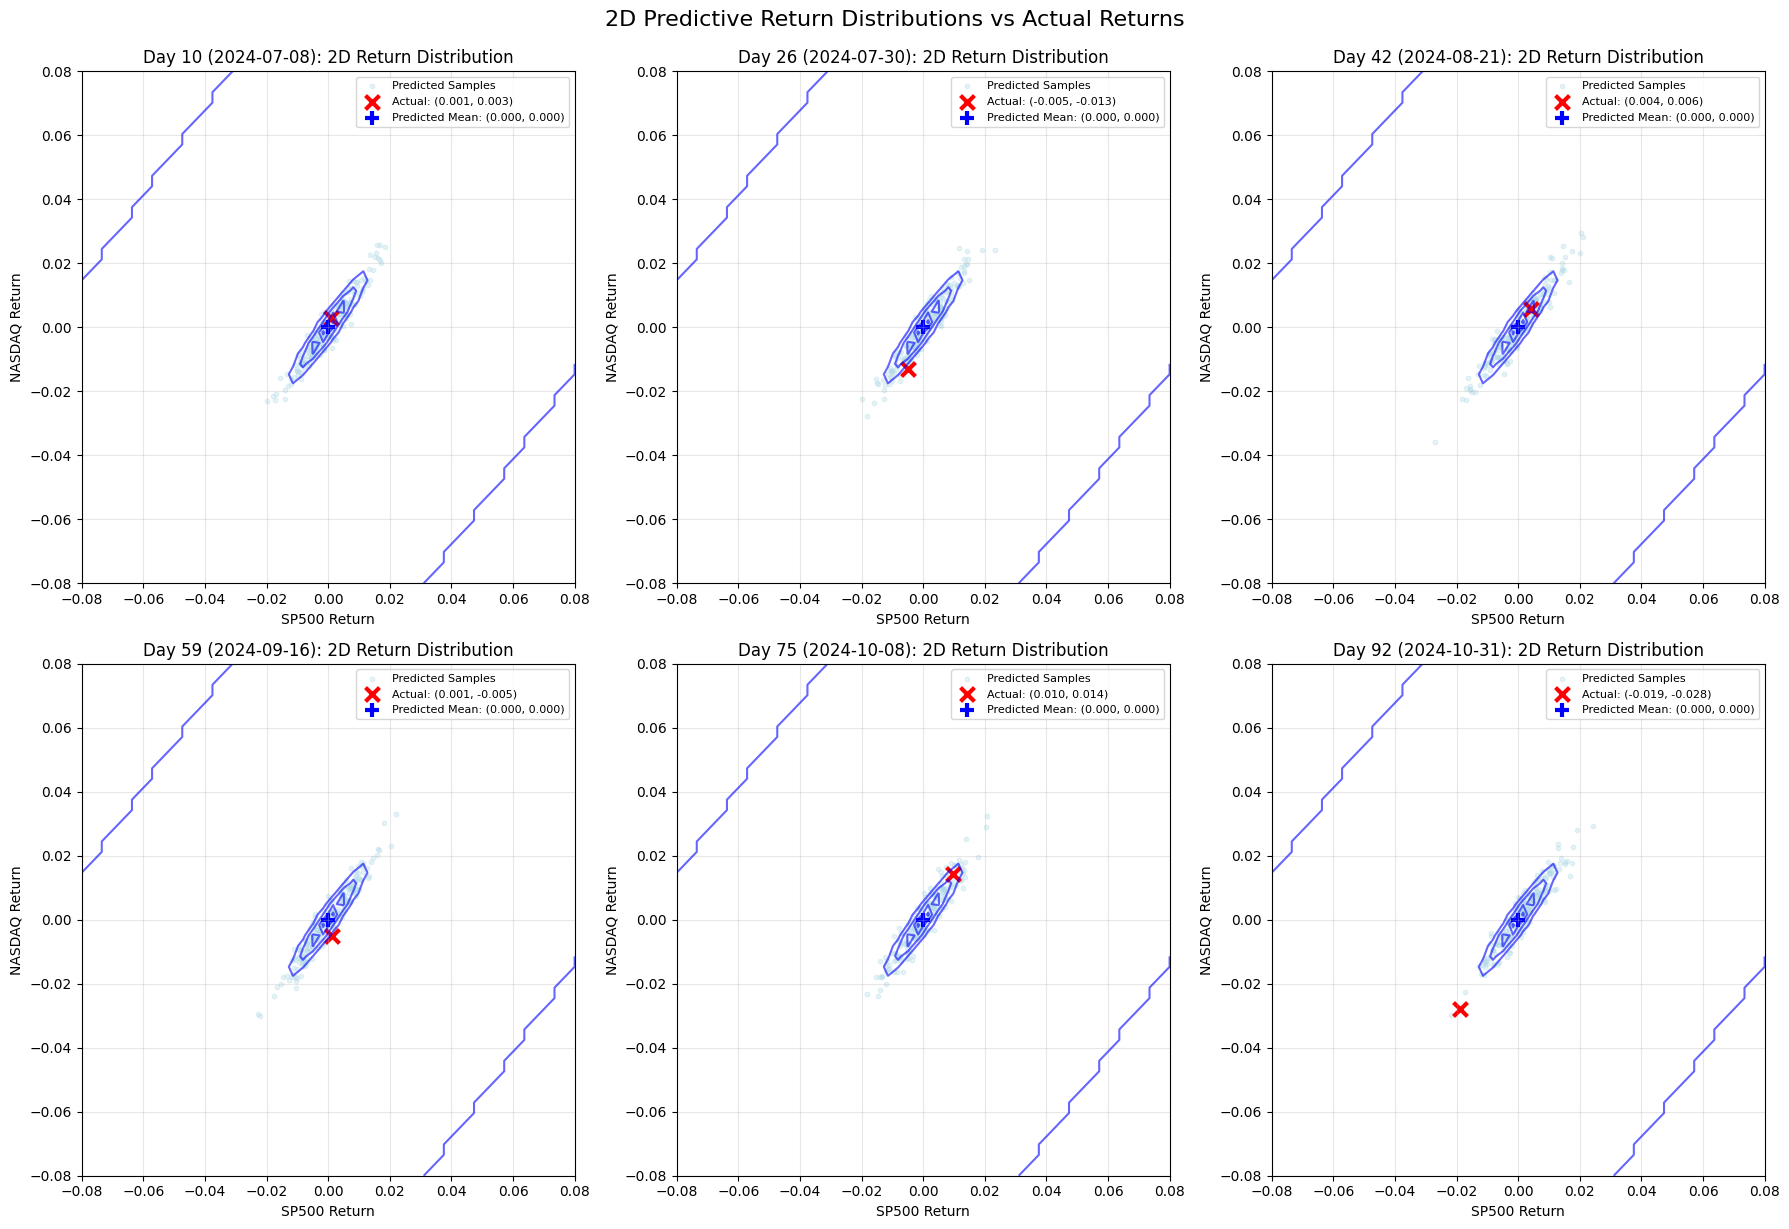

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Using constant volatilities from DC-MSV parameters


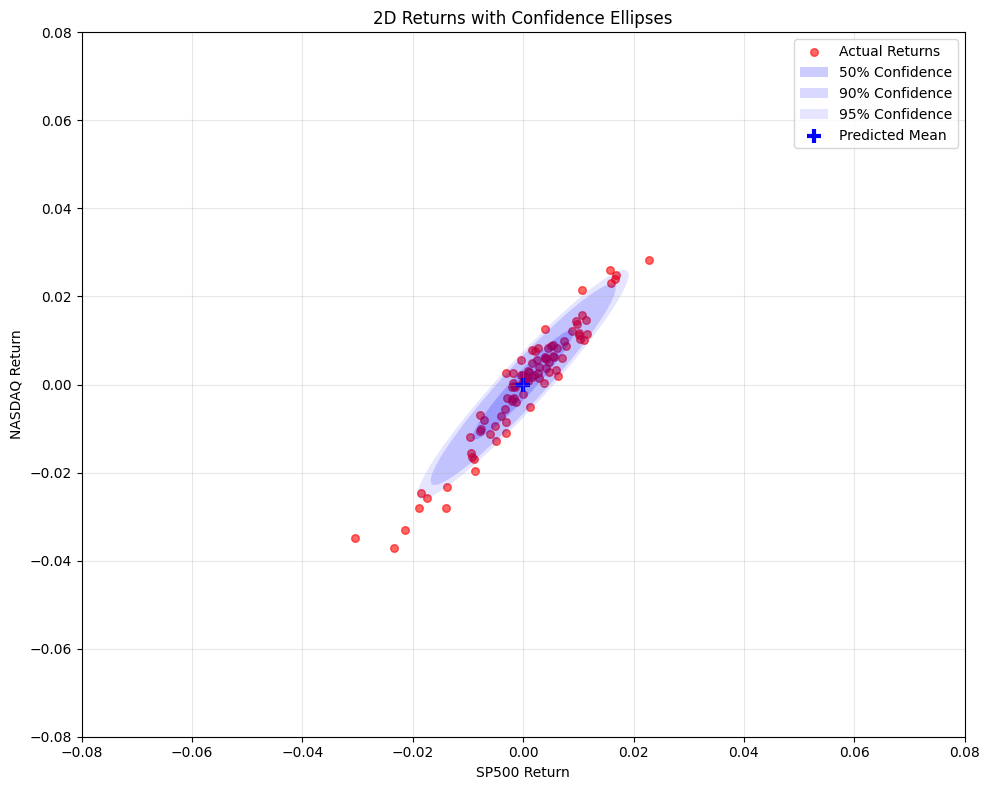

📊 2D Prediction Coverage Statistics:
Multivariate Coverage (Mahalanobis):
  50% region: 50.0% (target: 50%)
  90% region: 78.3% (target: 90%)
  95% region: 87.0% (target: 95%)
3. Correlation structure analysis:


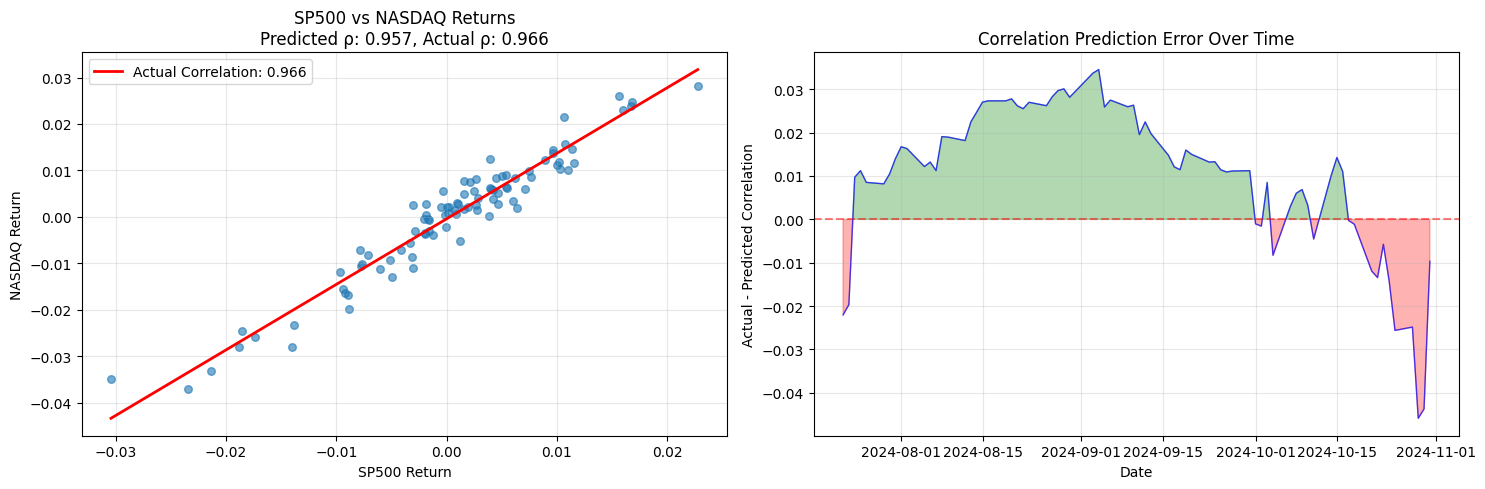

📊 Correlation Analysis Summary:
DC-MSV Predicted Correlation: 0.9572
Sample Correlation:           0.9664
Correlation Error:            0.0093
Mean 20-day Rolling Corr:     0.9674
Std 20-day Rolling Corr:      0.0171


In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

def plot_2d_return_distributions(dc_msv_params, actual_returns, test_df, n_examples=6):
    """
    Plot predictive 2D return distributions vs actual returns for selected time points
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Start from day 10 and select time points evenly spaced throughout the test period
    start_point = 9  # Day 10 (0-indexed)
    max_point = len(actual_returns) - 1
    time_points = np.linspace(start_point, max_point, n_examples, dtype=int)
    
    # Extract DC-MSV parameters
    mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
    mu0 = dc_msv_params['mu0']['mean']
    sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
    
    # Average correlation and volatilities
    rho_mean = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    vol1 = np.exp(mu1/2) * np.exp(sigma1**2/8)
    vol2 = np.exp(mu2/2) * np.exp(sigma2**2/8)
    
    # Covariance matrix
    cov = np.array([[vol1**2, rho_mean * vol1 * vol2],
                    [rho_mean * vol1 * vol2, vol2**2]])
    
    for i, t in enumerate(time_points):
        if t < len(actual_returns):
            # Generate samples from predictive distribution
            n_samples = 1000
            pred_samples = np.random.multivariate_normal([0, 0], cov, n_samples)
            
            # Plot predictive distribution as contour
            x_range = np.linspace(-0.08, 0.08, 50)
            y_range = np.linspace(-0.08, 0.08, 50)
            X, Y = np.meshgrid(x_range, y_range)
            pos = np.dstack((X, Y))
            
            # Create multivariate normal for contour plotting
            from scipy.stats import multivariate_normal
            rv = multivariate_normal([0, 0], cov)
            
            # Plot contours
            axes[i].contour(X, Y, rv.pdf(pos), colors='blue', alpha=0.6, levels=5)
            
            # Scatter plot of samples
            axes[i].scatter(pred_samples[:200, 0], pred_samples[:200, 1], 
                           alpha=0.3, s=10, color='lightblue', label='Predicted Samples')
            
            # Add actual return as red point
            actual_sp500 = actual_returns[t, 0]
            actual_nasdaq = actual_returns[t, 1]
            axes[i].scatter(actual_sp500, actual_nasdaq, color='red', s=100, 
                           marker='x', linewidth=3, label=f'Actual: ({actual_sp500:.3f}, {actual_nasdaq:.3f})')
            
            # Add predicted mean
            axes[i].scatter(0, 0, color='blue', s=100, marker='+', linewidth=3,
                           label='Predicted Mean: (0.000, 0.000)')
            
            date_str = test_df.index[t].strftime('%Y-%m-%d')
            axes[i].set_title(f'Day {t+1} ({date_str}): 2D Return Distribution')
            axes[i].set_xlabel('SP500 Return')
            axes[i].set_ylabel('NASDAQ Return')
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(-0.08, 0.08)
            axes[i].set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.suptitle('2D Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

def plot_2d_quantile_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze 2D prediction quality using time-varying volatilities from filtering results
    """
    # Try to use filtering results for time-varying volatilities if available
    try:
        if 'filtering_results' in globals() and filtering_results is not None:
            # Check if filtering_results has the expected structure
            if isinstance(filtering_results, dict) and 'filtered_states' in filtering_results:
                # Extract time-varying volatilities from filtered states
                filtered_states = filtering_results['filtered_states']
                h1_filtered = filtered_states['h1_mean']
                h2_filtered = filtered_states['h2_mean'] 
                q_filtered = filtered_states['q_mean']
                
                # Convert to actual volatilities and correlations (daily scale)
                vol1_daily = np.exp(h1_filtered / 2)  # Daily volatility
                vol2_daily = np.exp(h2_filtered / 2)  # Daily volatility
                rho_daily = (np.exp(q_filtered) - 1) / (np.exp(q_filtered) + 1)
                
                # Ensure we have the right length (match test period)
                n_periods = len(actual_returns)
                if len(vol1_daily) > n_periods:
                    vol1_daily = vol1_daily[:n_periods]
                    vol2_daily = vol2_daily[:n_periods]
                    rho_daily = rho_daily[:n_periods]
                elif len(vol1_daily) < n_periods:
                    # Extend with last values if needed
                    vol1_daily = np.pad(vol1_daily, (0, n_periods - len(vol1_daily)), 'edge')
                    vol2_daily = np.pad(vol2_daily, (0, n_periods - len(vol2_daily)), 'edge')
                    rho_daily = np.pad(rho_daily, (0, n_periods - len(rho_daily)), 'edge')
                
                print("Using time-varying volatilities from filtering results")
                use_time_varying = True
            else:
                raise KeyError("filtering_results structure not as expected")
        else:
            raise NameError("filtering_results not available")
    except (NameError, KeyError, IndexError, TypeError) as e:
        print(f"Falling back to constant volatilities: {e}")
        use_time_varying = False
        
    if not use_time_varying:
        # Fallback: use constant estimates from DC-MSV parameters
        mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
        mu0 = dc_msv_params['mu0']['mean']
        sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
        
        # Constant volatilities and correlation
        vol1_const = np.exp(mu1/2) * np.exp(sigma1**2/8)
        vol2_const = np.exp(mu2/2) * np.exp(sigma2**2/8)
        rho_const = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
        
        # Create arrays for time-varying (but actually constant) values
        n_periods = len(actual_returns)
        vol1_daily = np.full(n_periods, vol1_const)
        vol2_daily = np.full(n_periods, vol2_const)
        rho_daily = np.full(n_periods, rho_const)
        print("Using constant volatilities from DC-MSV parameters")
    
    n_periods = len(actual_returns)
    
    # Calculate time-varying prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    sp500_quantiles_time = np.zeros((5, n_periods))
    nasdaq_quantiles_time = np.zeros((5, n_periods))
    
    for t in range(n_periods):
        for i, q in enumerate(quantiles):
            sp500_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol1_daily[t])
            nasdaq_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol2_daily[t])
    
    
    # Calculate time-varying Mahalanobis distances
    from scipy.stats import chi2
    mahal_distances = []
    for t in range(n_periods):
        # Time-varying covariance matrix
        cov_t = np.array([[vol1_daily[t]**2, rho_daily[t] * vol1_daily[t] * vol2_daily[t]],
                         [rho_daily[t] * vol1_daily[t] * vol2_daily[t], vol2_daily[t]**2]])
        diff = actual_returns[t] - np.array([0, 0])
        mahal_dist = np.sqrt(diff.T @ np.linalg.inv(cov_t) @ diff)
        mahal_distances.append(mahal_dist)
    
    mahal_distances = np.array(mahal_distances)
    
    # Create time-varying prediction intervals 
    dates = test_df.index[:len(actual_returns)]
    
    # Create single plot - only 2D scatter with confidence ellipses
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # 2D scatter plot with confidence ellipses using average covariance
    from matplotlib.patches import Ellipse
    
    # Use average covariance for ellipse visualization
    avg_vol1 = np.mean(vol1_daily)
    avg_vol2 = np.mean(vol2_daily)
    avg_rho = np.mean(rho_daily)
    avg_cov = np.array([[avg_vol1**2, avg_rho * avg_vol1 * avg_vol2],
                       [avg_rho * avg_vol1 * avg_vol2, avg_vol2**2]])
    
    # Plot actual returns
    ax.scatter(actual_returns[:, 0], actual_returns[:, 1], 
               alpha=0.6, s=30, color='red', label='Actual Returns')
    
    # Add confidence ellipses
    eigenvals, eigenvecs = np.linalg.eigh(avg_cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # 50%, 90%, 95% confidence ellipses
    for confidence, color, alpha in [(0.5, 'blue', 0.2), (0.9, 'blue', 0.15), (0.95, 'blue', 0.1)]:
        chi2_val = chi2.ppf(confidence, df=2)
        width = 2 * np.sqrt(chi2_val * eigenvals[0])
        height = 2 * np.sqrt(chi2_val * eigenvals[1])
        
        ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                         facecolor=color, alpha=alpha, label=f'{confidence*100:.0f}% Confidence')
        ax.add_patch(ellipse)
    
    ax.scatter(0, 0, color='blue', s=100, marker='+', linewidth=3, label='Predicted Mean')
    ax.set_title('2D Returns with Confidence Ellipses')
    ax.set_xlabel('SP500 Return')
    ax.set_ylabel('NASDAQ Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.08, 0.08)
    ax.set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics using multivariate Mahalanobis distance only
    # Multivariate coverage using Mahalanobis distance
    mahal_coverage_50 = np.mean(mahal_distances**2 <= chi2.ppf(0.5, df=2))
    mahal_coverage_90 = np.mean(mahal_distances**2 <= chi2.ppf(0.9, df=2))
    mahal_coverage_95 = np.mean(mahal_distances**2 <= chi2.ppf(0.95, df=2))
    
    print(f"📊 2D Prediction Coverage Statistics:")
    print(f"=" * 50)
    print(f"Multivariate Coverage (Mahalanobis):")
    print(f"  50% region: {mahal_coverage_50:.1%} (target: 50%)")
    print(f"  90% region: {mahal_coverage_90:.1%} (target: 90%)")
    print(f"  95% region: {mahal_coverage_95:.1%} (target: 95%)")
    
    return {
        'multivariate_coverage': (mahal_coverage_50, mahal_coverage_90, mahal_coverage_95),
        'mahalanobis_distances': mahal_distances
    }

def plot_correlation_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze the predicted vs actual correlation structure
    """
    # Extract DC-MSV correlation parameter
    mu0 = dc_msv_params['mu0']['mean']
    predicted_correlation = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    
    # Calculate rolling correlation of actual returns
    returns_df = pd.DataFrame(actual_returns, columns=['SP500', 'NASDAQ'], index=test_df.index[:len(actual_returns)])
    
    # Different window sizes for rolling correlation
    windows = [20, 50, 100]
    
    # Only keep the second row plots - create 1 row with 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Calculate sample correlation
    sample_correlation = np.corrcoef(actual_returns.T)[0, 1]
    
    # 1. Scatter plot of returns with correlation info (was axes[1, 0])
    axes[0].scatter(actual_returns[:, 0], actual_returns[:, 1], alpha=0.6, s=30)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_returns[:, 0], actual_returns[:, 1])
    line_x = np.array([actual_returns[:, 0].min(), actual_returns[:, 0].max()])
    line_y = slope * line_x + intercept
    axes[0].plot(line_x, line_y, 'r-', linewidth=2, 
                   label=f'Actual Correlation: {r_value:.3f}')
    
    axes[0].set_title(f'SP500 vs NASDAQ Returns\nPredicted ρ: {predicted_correlation:.3f}, Actual ρ: {r_value:.3f}')
    axes[0].set_xlabel('SP500 Return')
    axes[0].set_ylabel('NASDAQ Return')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Correlation error over time (was axes[1, 1])
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ'])
        corr_error = rolling_corr_20 - predicted_correlation
        
        axes[1].plot(corr_error.index, corr_error.values, 'b-', linewidth=1, alpha=0.7)
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values > 0), alpha=0.3, color='green', interpolate=True)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values <= 0), alpha=0.3, color='red', interpolate=True)
        axes[1].set_title('Correlation Prediction Error Over Time')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Actual - Predicted Correlation')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis summary
    print(f"📊 Correlation Analysis Summary:")
    print(f"=" * 40)
    print(f"DC-MSV Predicted Correlation: {predicted_correlation:.4f}")
    print(f"Sample Correlation:           {sample_correlation:.4f}")
    print(f"Correlation Error:            {abs(sample_correlation - predicted_correlation):.4f}")
    
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ']).dropna()
        mean_rolling_corr = rolling_corr_20.mean()
        std_rolling_corr = rolling_corr_20.std()
        
        print(f"Mean 20-day Rolling Corr:     {mean_rolling_corr:.4f}")
        print(f"Std 20-day Rolling Corr:      {std_rolling_corr:.4f}")
    
    return {
        'predicted_correlation': predicted_correlation,
        'sample_correlation': sample_correlation,
        'correlation_error': abs(sample_correlation - predicted_correlation)
    }

# Run the 2D visualizations
print("📊 Creating 2D return distribution visualizations...")

# 1. 2D Distribution snapshots at different time points
print("1. 2D Predictive distributions at selected time points:")
plot_2d_return_distributions(results['estimates'], test_array_decimal, test_df)

# 2. 2D Quantile-based analysis
print("2. 2D Prediction intervals and coverage:")
coverage_stats_2d = plot_2d_quantile_analysis(results['estimates'], test_array_decimal, test_df)

# 3. Correlation analysis
print("3. Correlation structure analysis:")
correlation_stats = plot_correlation_analysis(results['estimates'], test_array_decimal, test_df)

4. Dynamic Volatility Surface Analysis:


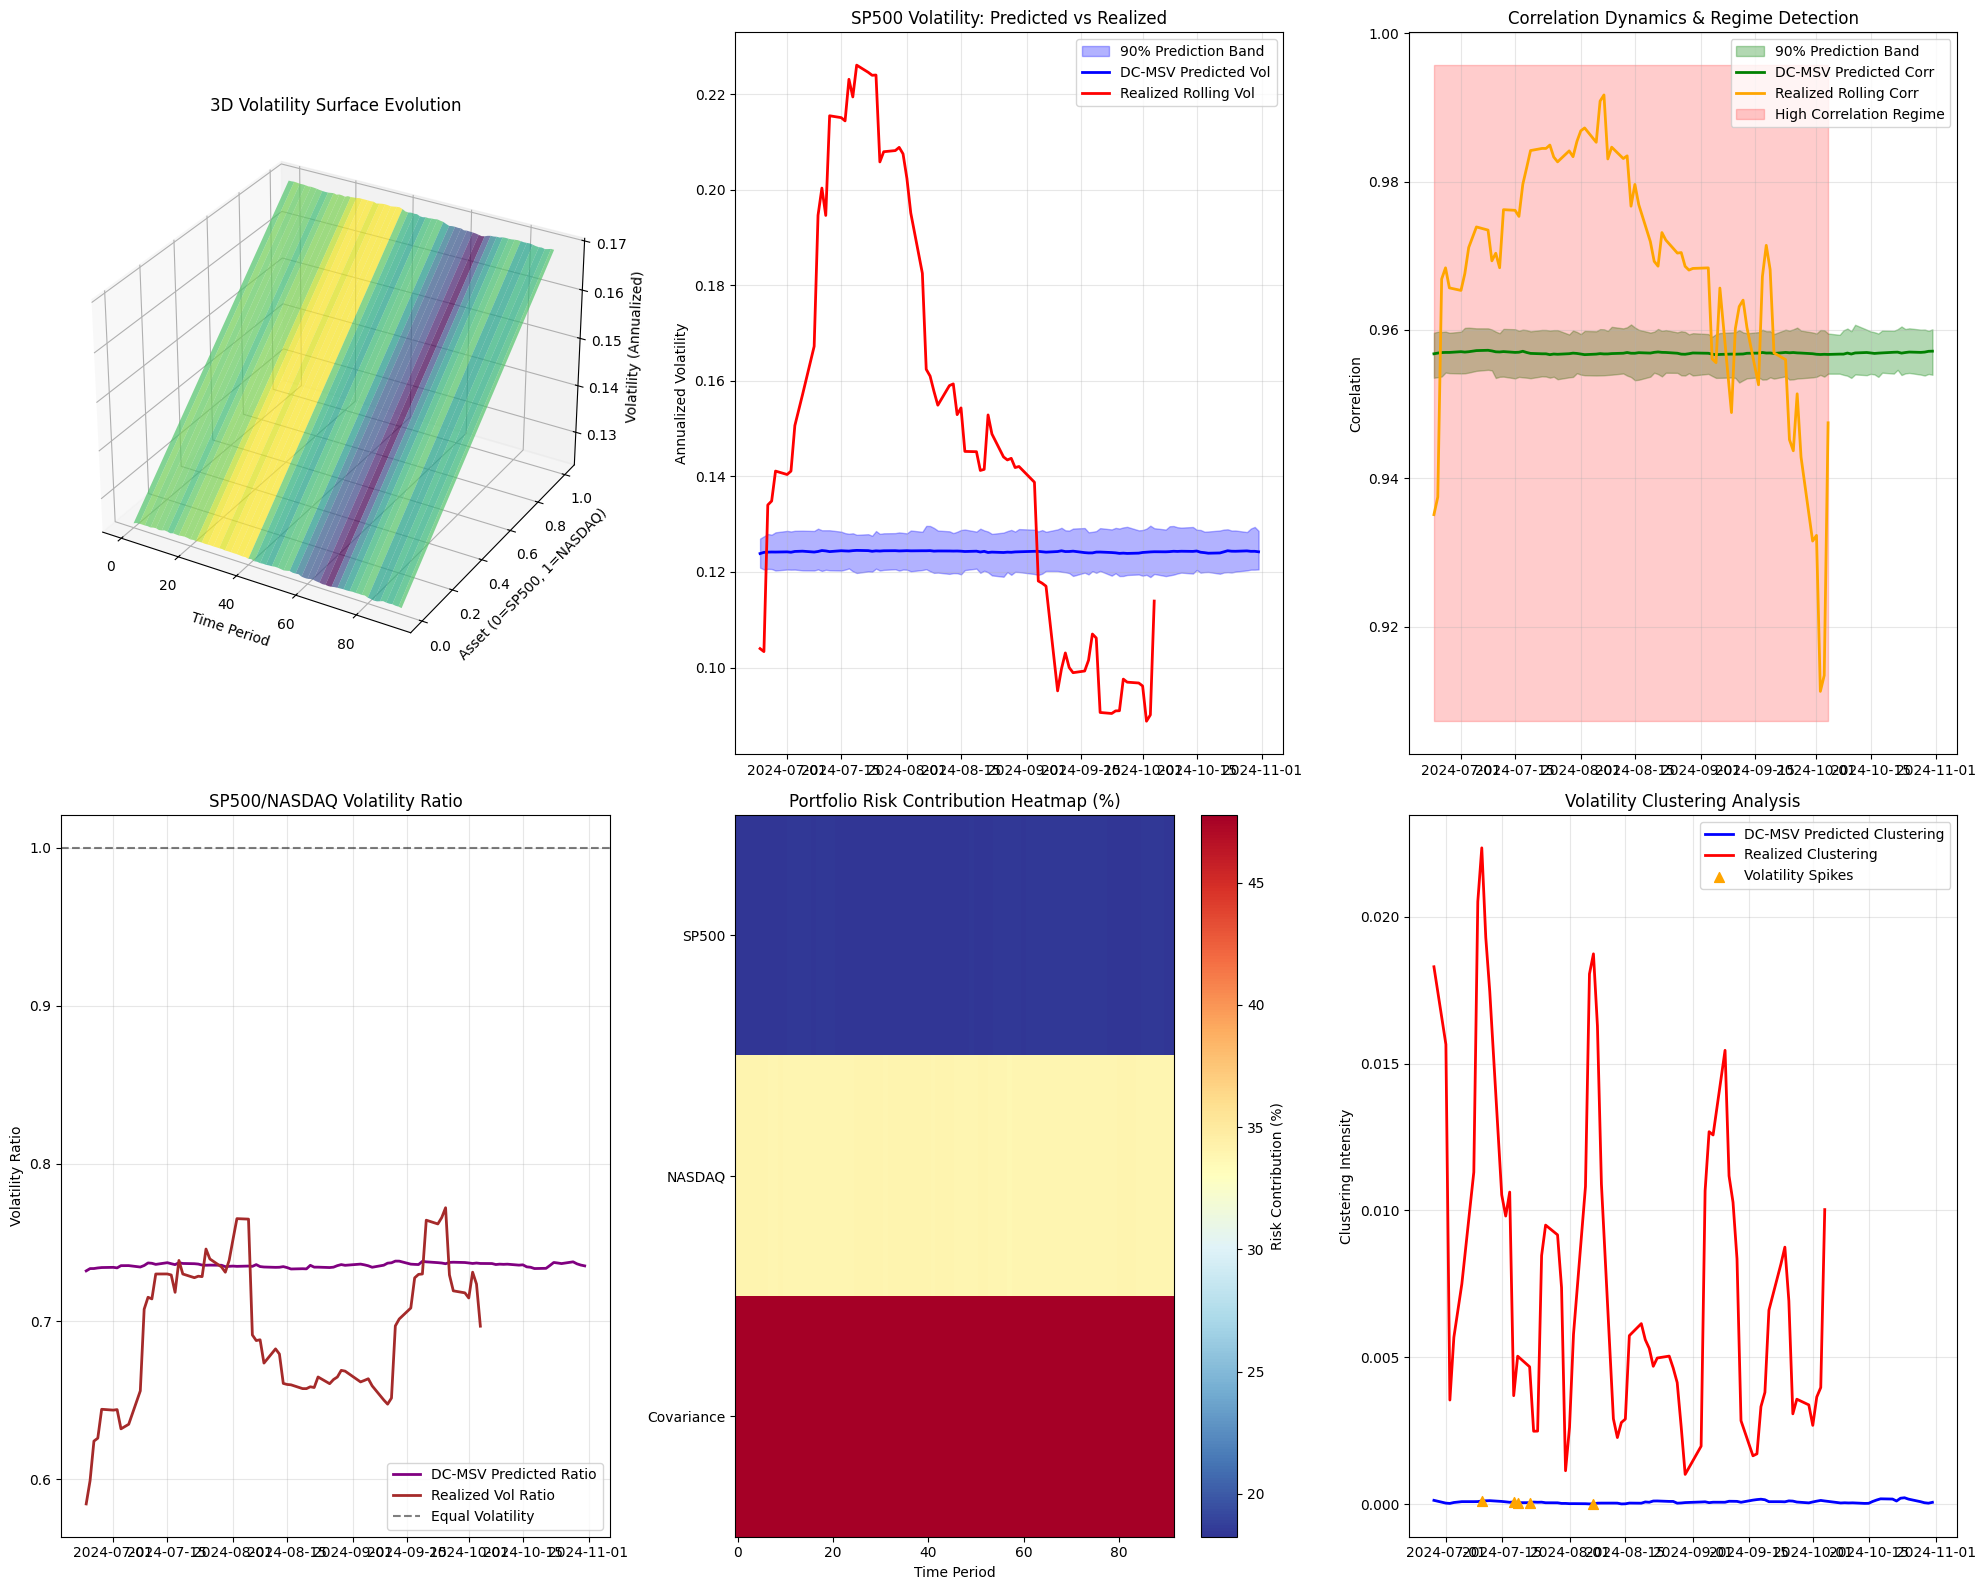

📊 Advanced Volatility Surface Analysis:
Volatility Prediction Accuracy (MAPE):
  SP500:  25.56%
  NASDAQ: 27.54%
  Correlation: 1.79%

Volatility Clustering Correlation: 0.035
Portfolio Risk Contribution Stability: 1.000

Regime Detection:
  High correlation periods: 73 days (100.0%)
  Low correlation periods:  0 days (0.0%)


In [112]:
def plot_dynamic_volatility_surface_analysis(dc_msv_params, actual_returns, test_df, train_array_decimal):
    """
    Advanced visualization of dynamic volatility surfaces and correlation evolution
    This shows the time-varying nature of the DC-MSV model vs static baselines
    """
    import matplotlib.dates as mdates
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    
    # Extract DC-MSV parameters
    mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
    phi11, phi22 = dc_msv_params['phi11']['mean'], dc_msv_params['phi22']['mean']
    sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
    mu0 = dc_msv_params['mu0']['mean']
    phi = dc_msv_params['phi']['mean']
    sigma_rho = dc_msv_params['sigma_rho']['mean']
    
    # Simulate the latent volatility processes for visualization
    def simulate_volatility_paths(n_periods=len(actual_returns), n_sims=100):
        """Simulate multiple paths of the latent volatility states"""
        h1_paths = np.zeros((n_sims, n_periods))
        h2_paths = np.zeros((n_sims, n_periods))
        q_paths = np.zeros((n_sims, n_periods))
        
        # Initialize at steady state
        h1_paths[:, 0] = np.random.normal(mu1, sigma1/np.sqrt(1-phi11**2), n_sims)
        h2_paths[:, 0] = np.random.normal(mu2, sigma2/np.sqrt(1-phi22**2), n_sims)
        q_paths[:, 0] = np.random.normal(mu0, sigma_rho/np.sqrt(1-phi**2), n_sims)
        
        for t in range(1, n_periods):
            h1_paths[:, t] = mu1 + phi11 * (h1_paths[:, t-1] - mu1) + np.random.normal(0, sigma1, n_sims)
            h2_paths[:, t] = mu2 + phi22 * (h2_paths[:, t-1] - mu2) + np.random.normal(0, sigma2, n_sims)
            q_paths[:, t] = mu0 + phi * (q_paths[:, t-1] - mu0) + np.random.normal(0, sigma_rho, n_sims)
        
        return h1_paths, h2_paths, q_paths
    
    h1_sims, h2_sims, q_sims = simulate_volatility_paths()
    
    # Convert to volatilities and correlations
    vol1_sims = np.exp(h1_sims / 2)
    vol2_sims = np.exp(h2_sims / 2)
    rho_sims = (np.exp(q_sims) - 1) / (np.exp(q_sims) + 1)
    
    # Get empirical rolling volatilities for comparison
    returns_df = pd.DataFrame(actual_returns, columns=['SP500', 'NASDAQ'], 
                             index=test_df.index[:len(actual_returns)])
    
    # Calculate rolling volatilities (annualized)
    window = 20
    rolling_vol1 = returns_df['SP500'].rolling(window=window).std() * np.sqrt(252)
    rolling_vol2 = returns_df['NASDAQ'].rolling(window=window).std() * np.sqrt(252)
    rolling_corr = returns_df['SP500'].rolling(window=window).corr(returns_df['NASDAQ'])
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 3D Volatility Surface (top-left)
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    dates_numeric = np.arange(len(actual_returns))  # Use numerical indices instead
    
    # Plot mean volatility surfaces
    vol1_mean = np.mean(vol1_sims, axis=0) * np.sqrt(252)  # Annualized
    vol2_mean = np.mean(vol2_sims, axis=0) * np.sqrt(252)
    
    # Create proper meshgrid for 3D surface
    X, Y = np.meshgrid(dates_numeric[:len(vol1_mean)], [0, 1])  # Use numerical asset indices
    Z = np.vstack([vol1_mean, vol2_mean])
    
    surf = ax1.plot_surface(X, Y, Z, alpha=0.7, cmap='viridis')
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Asset (0=SP500, 1=NASDAQ)')
    ax1.set_zlabel('Volatility (Annualized)')
    ax1.set_title('3D Volatility Surface Evolution')
    
    # 2. Volatility Bands with Uncertainty (top-middle)
    ax2 = fig.add_subplot(2, 3, 2)
    dates = test_df.index[:len(actual_returns)]
    
    # Plot prediction bands
    vol1_q05 = np.percentile(vol1_sims * np.sqrt(252), 5, axis=0)
    vol1_q95 = np.percentile(vol1_sims * np.sqrt(252), 95, axis=0)
    vol1_mean_ann = vol1_mean
    
    ax2.fill_between(dates, vol1_q05, vol1_q95, alpha=0.3, color='blue', label='90% Prediction Band')
    ax2.plot(dates, vol1_mean_ann, 'b-', linewidth=2, label='DC-MSV Predicted Vol')
    
    # Handle potential NaN values in rolling volatility
    rolling_vol1_clean = rolling_vol1.dropna()
    dates_clean = dates[:len(rolling_vol1_clean)]
    ax2.plot(dates_clean, rolling_vol1_clean, 'r-', linewidth=2, label='Realized Rolling Vol')
    
    ax2.set_title('SP500 Volatility: Predicted vs Realized')
    ax2.set_ylabel('Annualized Volatility')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Correlation Dynamics with Regime Detection (top-right)
    ax3 = fig.add_subplot(2, 3, 3)
    
    rho_mean = np.mean(rho_sims, axis=0)
    rho_q05 = np.percentile(rho_sims, 5, axis=0)
    rho_q95 = np.percentile(rho_sims, 95, axis=0)
    
    ax3.fill_between(dates, rho_q05, rho_q95, alpha=0.3, color='green', label='90% Prediction Band')
    ax3.plot(dates, rho_mean, 'g-', linewidth=2, label='DC-MSV Predicted Corr')
    
    # Handle potential NaN values in rolling correlation
    rolling_corr_clean = rolling_corr.dropna()
    dates_corr_clean = dates[:len(rolling_corr_clean)]
    ax3.plot(dates_corr_clean, rolling_corr_clean, 'orange', linewidth=2, label='Realized Rolling Corr')
    
    # Add regime detection based on correlation levels
    high_corr_threshold = 0.8
    low_corr_threshold = 0.4
    
    high_corr_periods = rolling_corr_clean > high_corr_threshold
    low_corr_periods = rolling_corr_clean < low_corr_threshold
    
    if high_corr_periods.any():
        ax3.fill_between(dates_corr_clean, ax3.get_ylim()[0], ax3.get_ylim()[1], 
                        where=high_corr_periods, alpha=0.2, color='red', 
                        label='High Correlation Regime')
    
    ax3.set_title('Correlation Dynamics & Regime Detection')
    ax3.set_ylabel('Correlation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Volatility Ratio Analysis (bottom-left)
    ax4 = fig.add_subplot(2, 3, 4)
    
    vol_ratio_predicted = vol1_mean / vol2_mean
    
    # Calculate realized ratio with proper handling of NaN values
    rolling_vol1_ratio = rolling_vol1.dropna()
    rolling_vol2_ratio = rolling_vol2.dropna()
    min_len = min(len(rolling_vol1_ratio), len(rolling_vol2_ratio))
    
    if min_len > 0:
        vol_ratio_realized = rolling_vol1_ratio.iloc[:min_len] / rolling_vol2_ratio.iloc[:min_len]
        dates_ratio = dates[:min_len]
        
        ax4.plot(dates[:len(vol_ratio_predicted)], vol_ratio_predicted, 'purple', linewidth=2, label='DC-MSV Predicted Ratio')
        ax4.plot(dates_ratio, vol_ratio_realized, 'brown', linewidth=2, label='Realized Vol Ratio')
    else:
        ax4.plot(dates[:len(vol_ratio_predicted)], vol_ratio_predicted, 'purple', linewidth=2, label='DC-MSV Predicted Ratio')
    
    ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal Volatility')
    
    ax4.set_title('SP500/NASDAQ Volatility Ratio')
    ax4.set_ylabel('Volatility Ratio')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Risk Contribution Heatmap (bottom-middle)
    ax5 = fig.add_subplot(2, 3, 5)
    
    # Calculate portfolio risk contributions over time
    # Assume equal weights portfolio
    w1, w2 = 0.5, 0.5
    portfolio_var_components = np.zeros((len(actual_returns), 3))  # [SP500, NASDAQ, Covariance]
    
    for t in range(len(actual_returns)):
        vol1_t = vol1_mean[t]
        vol2_t = vol2_mean[t] 
        rho_t = rho_mean[t]
        
        portfolio_var_components[t, 0] = (w1 * vol1_t)**2  # SP500 contribution
        portfolio_var_components[t, 1] = (w2 * vol2_t)**2  # NASDAQ contribution
        portfolio_var_components[t, 2] = 2 * w1 * w2 * vol1_t * vol2_t * rho_t  # Covariance contribution
    
    # Normalize to percentages
    portfolio_var_total = np.sum(portfolio_var_components, axis=1, keepdims=True)
    portfolio_var_pct = portfolio_var_components / portfolio_var_total * 100
    
    # Create heatmap
    im = ax5.imshow(portfolio_var_pct.T, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax5.set_yticks([0, 1, 2])
    ax5.set_yticklabels(['SP500', 'NASDAQ', 'Covariance'])
    ax5.set_xlabel('Time Period')
    ax5.set_title('Portfolio Risk Contribution Heatmap (%)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax5)
    cbar.set_label('Risk Contribution (%)')
    
    # 6. Volatility Clustering Analysis (bottom-right)
    ax6 = fig.add_subplot(2, 3, 6)
    
    # Calculate volatility clustering metrics
    def volatility_clustering_metric(vol_series, window=5):
        """Calculate local volatility clustering using rolling std of volatilities"""
        return vol_series.rolling(window=window).std()
    
    vol1_clustering = volatility_clustering_metric(pd.Series(vol1_mean))
    
    # Handle NaN values in realized volatility clustering
    rolling_vol1_for_clustering = rolling_vol1.dropna()
    if len(rolling_vol1_for_clustering) > 0:
        realized_vol1_clustering = volatility_clustering_metric(rolling_vol1_for_clustering)
        dates_clustering = dates[:len(realized_vol1_clustering)]
        
        ax6.plot(dates[:len(vol1_clustering)], vol1_clustering, 'blue', linewidth=2, label='DC-MSV Predicted Clustering')
        ax6.plot(dates_clustering, realized_vol1_clustering, 'red', linewidth=2, label='Realized Clustering')
    else:
        ax6.plot(dates[:len(vol1_clustering)], vol1_clustering, 'blue', linewidth=2, label='DC-MSV Predicted Clustering')
    
    # Add volatility spike detection
    vol_spike_threshold = np.percentile(vol1_mean, 95)
    vol_spikes = vol1_mean > vol_spike_threshold
    
    if vol_spikes.any():
        spike_dates = dates[vol_spikes]
        ax6.scatter(spike_dates, vol1_clustering[vol_spikes], 
                   color='orange', s=50, marker='^', label='Volatility Spikes', zorder=5)
    
    ax6.set_title('Volatility Clustering Analysis')
    ax6.set_ylabel('Clustering Intensity')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print advanced metrics
    print(f"📊 Advanced Volatility Surface Analysis:")
    print(f"=" * 50)
    
    # Volatility prediction accuracy - handle NaN values properly
    rolling_vol1_clean = rolling_vol1.dropna()
    rolling_vol2_clean = rolling_vol2.dropna()
    
    if len(rolling_vol1_clean) > 0 and len(rolling_vol2_clean) > 0:
        min_len_vol = min(len(vol1_mean), len(rolling_vol1_clean))
        vol1_mape = np.mean(np.abs((vol1_mean[:min_len_vol] - rolling_vol1_clean.iloc[:min_len_vol]) / rolling_vol1_clean.iloc[:min_len_vol])) * 100
        
        min_len_vol2 = min(len(vol2_mean), len(rolling_vol2_clean))
        vol2_mape = np.mean(np.abs((vol2_mean[:min_len_vol2] - rolling_vol2_clean.iloc[:min_len_vol2]) / rolling_vol2_clean.iloc[:min_len_vol2])) * 100
    else:
        vol1_mape = vol2_mape = np.nan
    
    print(f"Volatility Prediction Accuracy (MAPE):")
    print(f"  SP500:  {vol1_mape:.2f}%" if not np.isnan(vol1_mape) else "  SP500:  N/A (insufficient data)")
    print(f"  NASDAQ: {vol2_mape:.2f}%" if not np.isnan(vol2_mape) else "  NASDAQ: N/A (insufficient data)")
    
    # Correlation prediction accuracy
    rolling_corr_clean = rolling_corr.dropna()
    if len(rolling_corr_clean) > 0:
        min_len_corr = min(len(rho_mean), len(rolling_corr_clean))
        corr_mape = np.mean(np.abs((rho_mean[:min_len_corr] - rolling_corr_clean.iloc[:min_len_corr]) / rolling_corr_clean.iloc[:min_len_corr])) * 100
        print(f"  Correlation: {corr_mape:.2f}%")
    else:
        corr_mape = np.nan
        print(f"  Correlation: N/A (insufficient data)")
    
    # Volatility clustering comparison
    if len(rolling_vol1_for_clustering) > 0 and len(vol1_clustering.dropna()) > 0:
        vol1_clust_clean = vol1_clustering.dropna()
        realized_vol1_clust_clean = realized_vol1_clustering.dropna()
        min_len_clust = min(len(vol1_clust_clean), len(realized_vol1_clust_clean))
        
        if min_len_clust > 1:
            clustering_correlation = np.corrcoef(vol1_clust_clean.iloc[:min_len_clust], 
                                               realized_vol1_clust_clean.iloc[:min_len_clust])[0,1]
            print(f"\nVolatility Clustering Correlation: {clustering_correlation:.3f}")
        else:
            clustering_correlation = np.nan
            print(f"\nVolatility Clustering Correlation: N/A (insufficient data)")
    else:
        clustering_correlation = np.nan
        print(f"\nVolatility Clustering Correlation: N/A (insufficient data)")
    
    # Risk contribution stability
    risk_contrib_stability = 1 - np.std(portfolio_var_pct, axis=0).mean() / 100
    print(f"Portfolio Risk Contribution Stability: {risk_contrib_stability:.3f}")
    
    # Regime detection summary
    if len(rolling_corr_clean) > 0:
        n_high_corr = high_corr_periods.sum() if high_corr_periods.any() else 0
        n_low_corr = low_corr_periods.sum() if low_corr_periods.any() else 0
        print(f"\nRegime Detection:")
        print(f"  High correlation periods: {n_high_corr} days ({n_high_corr/len(rolling_corr_clean)*100:.1f}%)")
        print(f"  Low correlation periods:  {n_low_corr} days ({n_low_corr/len(rolling_corr_clean)*100:.1f}%)")
    else:
        n_high_corr = n_low_corr = 0
        print(f"\nRegime Detection: N/A (insufficient data)")
    
    return {
        'volatility_accuracy': {'sp500_mape': vol1_mape, 'nasdaq_mape': vol2_mape},
        'correlation_accuracy': corr_mape,
        'clustering_correlation': clustering_correlation,
        'risk_contribution_stability': risk_contrib_stability,
        'regime_stats': {'high_corr_days': n_high_corr, 'low_corr_days': n_low_corr}
    }

# Run the advanced 4th visualization
print("4. Dynamic Volatility Surface Analysis:")
volatility_analysis = plot_dynamic_volatility_surface_analysis(
    results['estimates'], test_array_decimal, test_df, train_array_decimal
)

# 🎯 Particle Filtering and Smoothing for 2D DC-MSV

## Advanced State Estimation and Latent Variable Recovery

The 2D Dynamic Correlation Multivariate Stochastic Volatility (DC-MSV) model presents a sophisticated challenge for state estimation due to its:

1. **Non-linear dynamics** in the correlation process
2. **High-dimensional latent states** (3D: two volatilities + correlation)
3. **Complex interdependencies** between assets
4. **Time-varying correlation structure**

### Particle Filtering vs. Smoothing

| Method | Purpose | Computational Cost | Information Used |
|--------|---------|-------------------|------------------|
| **Particle Filter** | Real-time state estimation | O(N×T) | Past + current observations |
| **Particle Smoother** | Historical state reconstruction | O(N×T²) | Full observation sequence |

**Why Both Matter:**
- **Filtering**: Essential for real-time risk management and trading decisions
- **Smoothing**: Critical for parameter estimation, model validation, and historical analysis

### Implementation Strategy

We'll implement:
1. **Sequential Monte Carlo (SMC) Filter** for online state estimation
2. **Forward-Backward Smoother** for optimal historical state recovery
3. **Adaptive particle count** based on effective sample size
4. **Robust resampling** to prevent particle degeneracy
5. **State extraction and visualization** comparing filtered vs. smoothed estimates